In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import json
import pickle
import os
import sys
import gc
import xgboost as xgb

warnings.filterwarnings('ignore')

In [2]:
def get_models(initial_path):
    models = {}
    for inv_dir in os.listdir(initial_path):
        if ("inversor" in inv_dir.lower()) & (os.path.isdir(os.path.join(initial_path, inv_dir))):
            explotacion_path = os.path.join(initial_path, inv_dir, "Explotacion")
            for model_dir in os.listdir(explotacion_path):
                model_path = os.path.join(explotacion_path, model_dir)
                if os.path.isdir(model_path):
                    model_dict = {}
                    with open(os.path.join(model_path, "model.model"), "rb") as f:
                        model_dict["model"] = pickle.load(f)
                    with open(os.path.join(model_path, "informe_modelo.json"), "r") as f:
                        informe_modelo = json.load(f)
                        model_dict["intervalo"] = informe_modelo["intervalo_min"]
                        model_dict["normalizacion"] = informe_modelo["normalizacion"]
                        model_dict["RMSE"] = informe_modelo["metricas"]["RMSE"]
                    models[inv_dir] = model_dict
    return models

In [3]:
root_path = "/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo"
params = None
for filename in os.listdir(root_path):
    if "params.json" in filename:
        with open(os.path.join(root_path, filename)) as f:
            params = json.load(f)
if params is None:
    print("No se ha encontrado el archivo de parámetros para la conexión a la base de datos")
    sys.exit()
data_path = os.path.join(root_path, params["data_path"])
schema_name = params["schema"]

password = params['password'].replace('@', '%40')
engine = create_engine(f'postgresql://{params["user"]}:{password}@{params["host"]}:{params["port"]}/{params["dbname"]}')
print(f"Conexión a la base de datos {params['dbname']} (esquema {schema_name}) establecida")

Conexión a la base de datos fvpredictive (esquema galisteo) establecida


In [4]:
model_path = os.path.join(root_path, "Modelos", "potencia_inversor_promedio")
models_dict = get_models(model_path)

In [5]:
for inv in models_dict:
    dispositivo_id = int(inv.split("_")[1]) + 20
    intervalo = models_dict[inv]["intervalo"]
    normalizacion = models_dict[inv]["normalizacion"]
    main_query = f"""
        WITH inv AS (
            SELECT 
                date_trunc('hour', datetime_utc) + 
                INTERVAL '{intervalo} min' * floor(date_part('minute', datetime_utc) / {intervalo}) as datetime_utc_rounded,
                dispositivo_id,
                MIN(inv.id) AS id, 
                AVG(potencia_act) as potencia_act
            FROM {schema_name}.inversores AS inv
            WHERE dispositivo_id = {dispositivo_id}
            GROUP BY datetime_utc_rounded, dispositivo_id 
        ),
        met AS (
            SELECT 
                date_trunc('hour', datetime_utc) + 
                INTERVAL '{intervalo} min' * floor(date_part('minute', datetime_utc) / {intervalo}) as datetime_utc_rounded, 
                dispositivo_id,
                AVG(rad_poa) AS rad_poa, 
                AVG(rad_hor) AS rad_hor, 
                AVG(rad_celda1) AS rad_celda1,
                AVG(rad_celda2) AS rad_celda2, 
                AVG(temp_amb) AS temp_amb, 
                AVG(temp_panel1) AS temp_panel1,
                AVG(temp_panel2) AS temp_panel2, 
                AVG(cloud_impact) AS cloud_impact,
                BOOL_OR(daylight) AS daylight
            FROM {schema_name}.meteo
                WHERE daylight = true
            GROUP BY dispositivo_id, datetime_utc_rounded
        )
        SELECT 
            inv.id,
            inv.dispositivo_id,
            inv.datetime_utc_rounded as datetime_utc, 
            potencia_act,
            rad_poa,
            rad_hor, 
            rad_celda1, 
            rad_celda2, 
            temp_amb, 
            temp_panel1, 
            temp_panel2,
            cloud_impact,
            motivo,
            consigna_pot_act_planta
        FROM inv
        JOIN {schema_name}.dispositivos AS disp
            ON disp.dispositivo_id = inv.dispositivo_id
        JOIN met
            ON met.datetime_utc_rounded = inv.datetime_utc_rounded
                AND met.dispositivo_id = disp.meteo_cercana_id
        JOIN {schema_name}.ree AS ree
            ON ree.datetime_utc = inv.datetime_utc_rounded
        ORDER BY 5, 2, 3, 4;"""

    chunksize = 100000
    chunks = pd.read_sql_query(main_query, engine, chunksize=chunksize)
    main_df = pd.DataFrame()
    for chunk in chunks:
        main_df = pd.concat([main_df, chunk], ignore_index = True)
    del chunks, chunk
    gc.collect()

In [6]:
models_dict

{'Inversor_11': {'model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('cat',
                                                    Pipeline(steps=[('onehot',
                                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                                    ['motivo']),
                                                   ('norm',
                                                    Pipeline(steps=[('minmax_scaler',
                                                                     MinMaxScaler())]),
                                                    ['rad_poa', 'temp_amb',
                                                     'rad_diff', 'temp_panel']),
                                                   ('std',
                                                    Pipeline(steps=[('std_scaler',
                               

In [7]:
main_df

,id,dispositivo_id,datetime_utc,potencia_act,rad_poa,rad_hor,rad_celda1,rad_celda2,temp_amb,temp_panel1,temp_panel2,cloud_impact,motivo,consigna_pot_act_planta
0,5576367,30,2023-08-28 11:45:00+02:00,2626.666667,0.000000,704.743335,956.909998,893.673336,25.246667,45.933333,45.456667,100.000000,1,33.6
1,2192063,30,2023-05-29 21:45:00+02:00,0.000000,0.650000,1.050000,1.025000,0.825000,15.775000,16.500000,16.175001,100.000000,0,38.7
2,2505486,30,2023-06-07 06:45:00+02:00,0.000000,0.700000,1.020000,0.660000,0.490000,18.000000,18.480000,18.190001,100.000000,0,38.7
3,18457405,30,2022-11-08 18:15:00+01:00,0.000000,0.725000,0.925000,1.625000,1.275000,22.600000,16.675001,16.225000,100.000000,0,38.7
4,16349825,30,2022-09-13 08:00:00+02:00,0.000000,0.733333,0.958333,1.150000,1.120833,26.487500,19.908333,19.629167,100.000000,7,38.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25099,10865192,30,2022-04-19 13:15:00+02:00,2684.900000,1179.553328,1139.483339,1163.206669,1149.896678,22.476667,35.873333,32.280000,85.886098,0,38.7
25100,13367215,30,2022-06-25 14:00:00+02:00,1414.500000,1180.123328,1191.739992,1159.126672,1153.723332,31.676667,43.596667,44.493334,106.713552,0,20.0
25101,13220965,30,2022-06-21 16:15:00+02:00,2936.133333,1195.743343,1090.370003,1170.526676,1147.470003,35.333333,55.626667,56.196667,99.499538,0,38.7
25102,3002995,30,2023-06-20 13:45:00+02:00,3152.933333,1207.473332,1214.629993,1168.739994,1171.299996,23.810000,50.886667,52.850000,94.391342,7,38.7


In [8]:
# Normalización de la entrada de corriente continua, formateo de fechas y escalado de potencia
print(f"\tCarga inicial de {main_df.shape[0]} registros")
main_df["datetime_utc"] = pd.to_datetime(main_df["datetime_utc"], utc = True)
main_df["potencia_act"] = main_df["potencia_act"] * 1000

	Carga inicial de 25104 registros


In [9]:
# Manipulación de variables meteorológicas
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"])
main_df["temp_panel"] = (main_df["temp_panel1"] + main_df["temp_panel2"]) / 2
main_df = main_df.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

In [10]:
# Manipulación de variables de consigna
main_query = f"""
    SELECT MAX(consigna_pot_act_planta)
        FROM {schema_name}.ree AS ree;"""
max_pot_act = pd.read_sql_query(main_query, engine).values[0][0]
main_df["consigna_pot_act_planta"] = main_df["consigna_pot_act_planta"] / max_pot_act 

In [11]:
# Asignación de variables temporales
main_df["dia_año"] = main_df["datetime_utc"].dt.dayofyear
main_df["dia_año_sen"] = np.sin(main_df["dia_año"] * (2*np.pi/365))
main_df["hora_seg"] = main_df["datetime_utc"].dt.hour * 3600 + \
                        main_df["datetime_utc"].dt.minute * 60 + \
                        main_df["datetime_utc"].dt.second
main_df["hora_seg_sen"] = np.sin(main_df["hora_seg"] * (2*np.pi/86400))

In [12]:
# Escalado de variables porcentuales
main_df[['cloud_impact']] = main_df[['cloud_impact']].apply(lambda x: x/100)

In [13]:
processed_df = main_df.drop(columns = ["id",
                "dia_año",
                "hora_seg"
                ]).set_index(["datetime_utc",
                                "dispositivo_id"])
y = processed_df[["potencia_act"]]
X = processed_df.drop(columns = ["potencia_act"])
X_prep = models_dict[inv]["model"].named_steps["preprocessor"].transform(X)
dtrain = xgb.DMatrix(X_prep)
y_pred = models_dict[inv]["model"].named_steps["regressor"].predict(dtrain)

In [14]:
target_df = y.copy()
target_df["pred"] = y_pred
target_df["diff"] = target_df["potencia_act"] - target_df["pred"]

In [15]:
lower_lim = models_dict[inv]["RMSE"]
upper_lim = 3 * models_dict[inv]["RMSE"]

In [16]:
target_df.reset_index(inplace = True)

In [17]:
target_df

,datetime_utc,dispositivo_id,potencia_act,pred,diff
0,2023-08-28 09:45:00+00:00,30,2.626667e+06,9.437066e+04,2.532296e+06
1,2023-05-29 19:45:00+00:00,30,0.000000e+00,8.861043e+04,-8.861043e+04
2,2023-06-07 04:45:00+00:00,30,0.000000e+00,9.514945e+04,-9.514945e+04
3,2022-11-08 17:15:00+00:00,30,0.000000e+00,9.185037e+04,-9.185037e+04
4,2022-09-13 06:00:00+00:00,30,0.000000e+00,9.147256e+04,-9.147256e+04
...,...,...,...,...,...
25099,2022-04-19 11:15:00+00:00,30,2.684900e+06,2.871269e+06,-1.863692e+05
25100,2022-06-25 12:00:00+00:00,30,1.414500e+06,1.602441e+06,-1.879411e+05
25101,2022-06-21 14:15:00+00:00,30,2.936133e+06,2.893270e+06,4.286358e+04
25102,2023-06-20 11:45:00+00:00,30,3.152933e+06,2.886806e+06,2.661268e+05


### PROMEDIADO DIARIO

In [18]:
daily_df = target_df.resample("D", on = "datetime_utc").mean().drop(columns = "dispositivo_id").reset_index()

In [19]:
daily_df["date"] = daily_df["datetime_utc"].dt.date
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df

,datetime_utc,potencia_act,pred,diff,date
0,2022-01-01 00:00:00+00:00,1.168125e+06,1.139399e+06,28726.698465,2022-01-01
1,2022-01-02 00:00:00+00:00,1.180685e+06,1.164935e+06,15749.696272,2022-01-02
2,2022-01-03 00:00:00+00:00,1.225893e+06,1.183178e+06,42714.552152,2022-01-03
3,2022-01-04 00:00:00+00:00,NaN,NaN,NaN,2022-01-04
4,2022-01-05 00:00:00+00:00,6.076615e+05,6.330718e+05,-25410.240585,2022-01-05
...,...,...,...,...,...
633,2023-09-26 00:00:00+00:00,2.023910e+06,1.987432e+06,36477.919377,2023-09-26
634,2023-09-27 00:00:00+00:00,1.938584e+06,1.906060e+06,32523.807079,2023-09-27
635,2023-09-28 00:00:00+00:00,1.642343e+06,1.641776e+06,567.109429,2023-09-28
636,2023-09-29 00:00:00+00:00,1.726755e+06,1.764877e+06,-38122.127658,2023-09-29


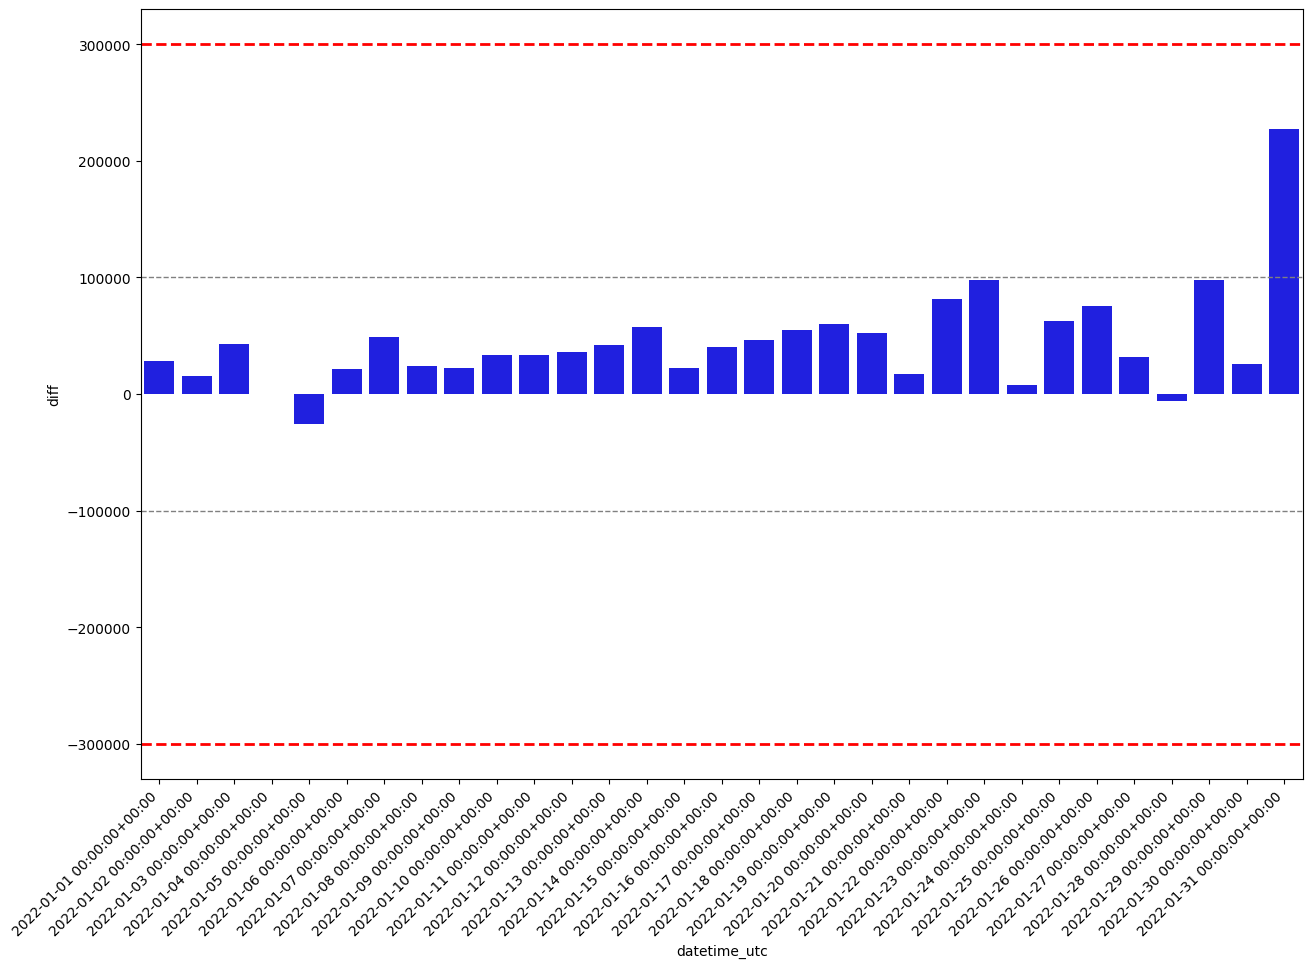

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(daily_df[(daily_df["datetime_utc"].dt.month == 1) & (daily_df["datetime_utc"].dt.year == 2022)], x="datetime_utc", y="diff", ax=ax, color="blue")

plt.xticks(rotation=45, ha='right')  # Girar las etiquetas al final de la cadena

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()


In [21]:
fallos_df = pd.read_csv('/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo/Datos/Nuevos/Historico alarmas galisteo 04_05_2023.csv', sep=';')
fallos_df["inversor"] = fallos_df["Equipment"].str.split(".").str[1]
fallos_df["fallo"] = fallos_df["Equipment"].str.split(".").str[2]
fallos_df = fallos_df[fallos_df["inversor"] == "INVERSOR_01"]
fallos_df = fallos_df[["inversor", "fallo", "NAME", "OnDate", "OnTime", "OffDate", "OffTime"]]
fallos_df['OnDate'] = pd.to_datetime(fallos_df['OnDate'])

daily_fallos_df = pd.merge(daily_df, fallos_df, left_on = 'date', right_on = 'OnDate', how = 'outer')
daily_fallos_df["soft_lim"] = np.abs(daily_fallos_df["diff"]) > lower_lim
daily_fallos_df["hard_lim"] = np.abs(daily_fallos_df["diff"]) > upper_lim

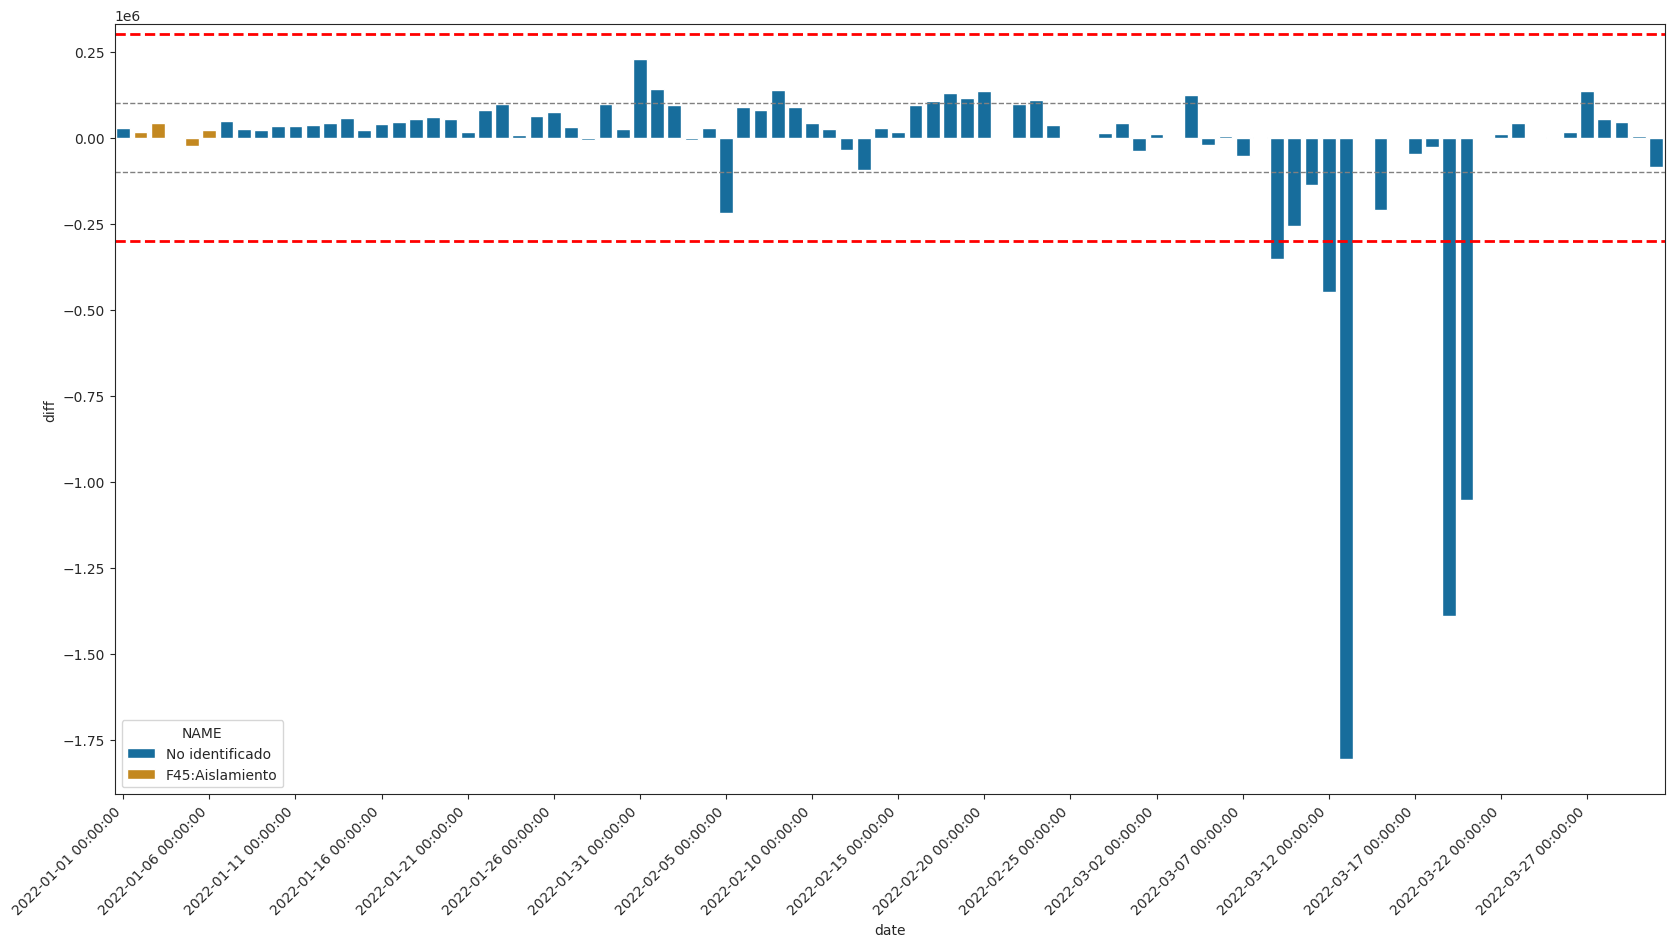

In [22]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 1) |
                               (daily_fallos_df["datetime_utc"].dt.month == 2) |
                               (daily_fallos_df["datetime_utc"].dt.month == 3)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

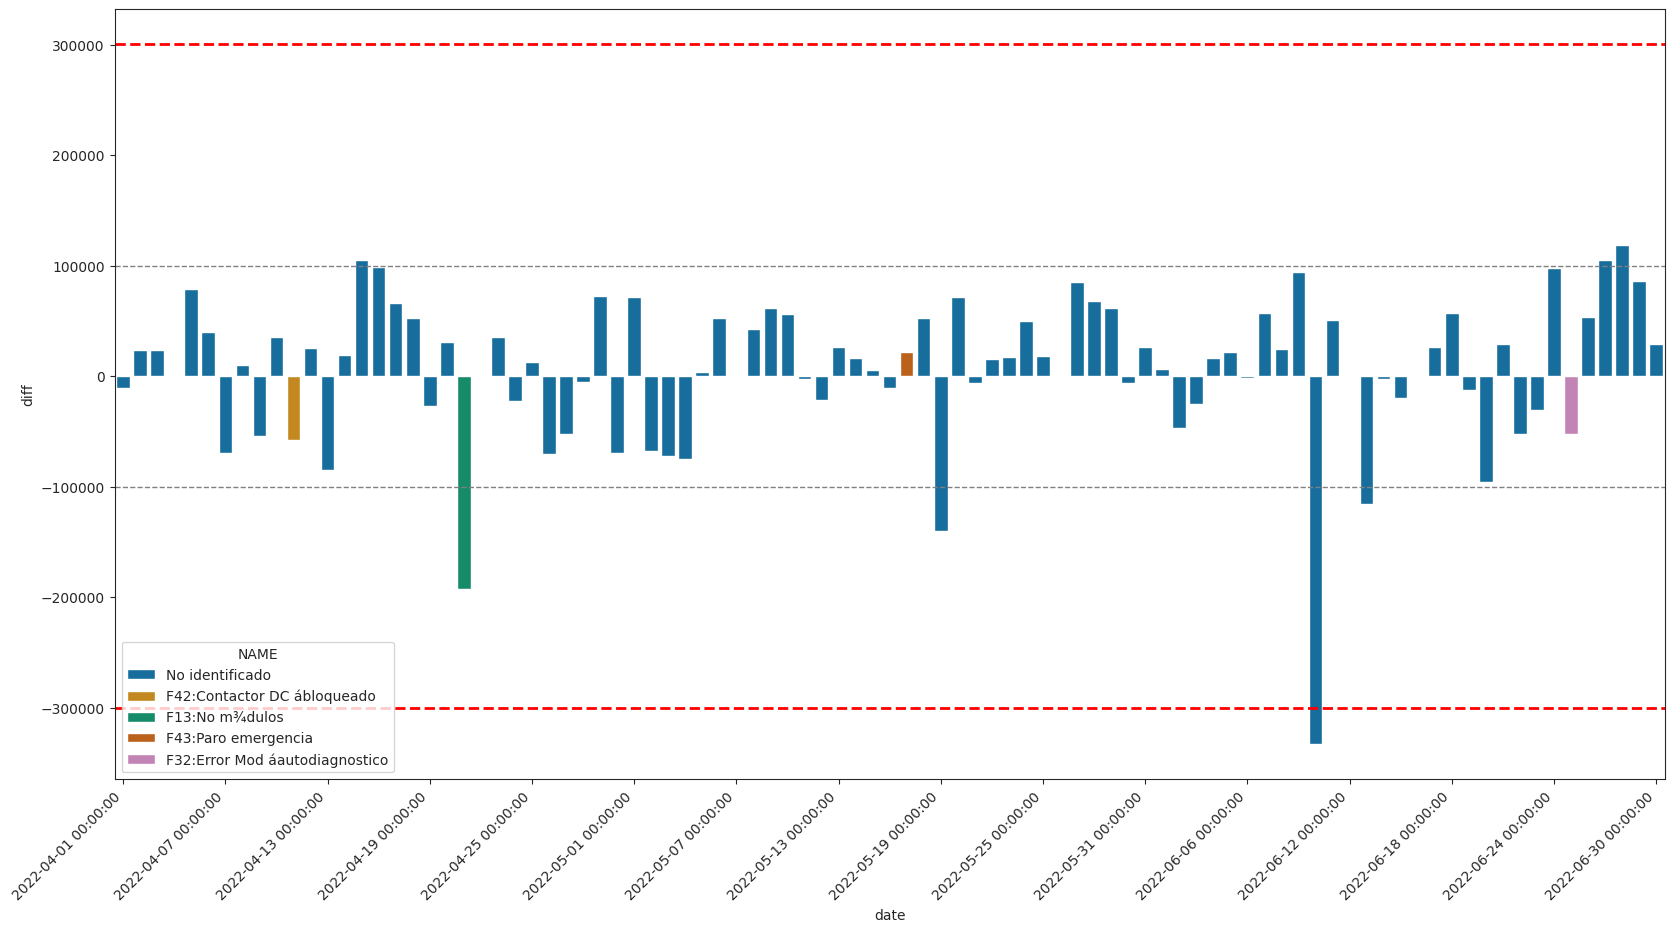

In [23]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 4) |
                               (daily_fallos_df["datetime_utc"].dt.month == 5) |
                               (daily_fallos_df["datetime_utc"].dt.month == 6)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

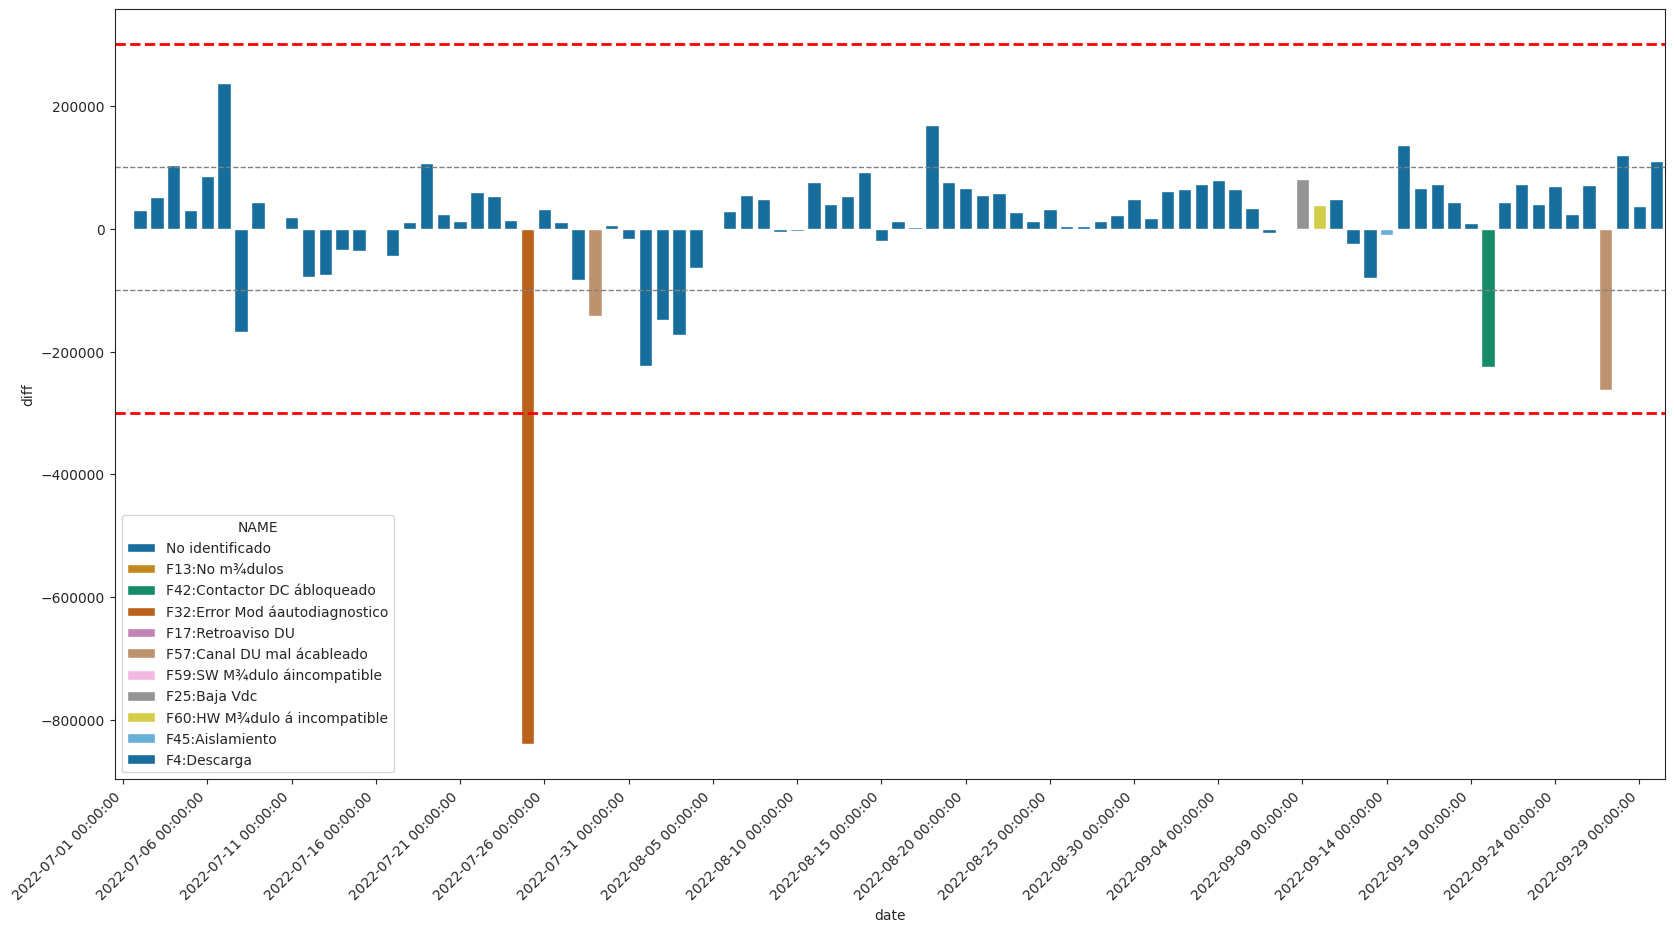

In [24]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 7) |
                               (daily_fallos_df["datetime_utc"].dt.month == 8) |
                               (daily_fallos_df["datetime_utc"].dt.month == 9)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

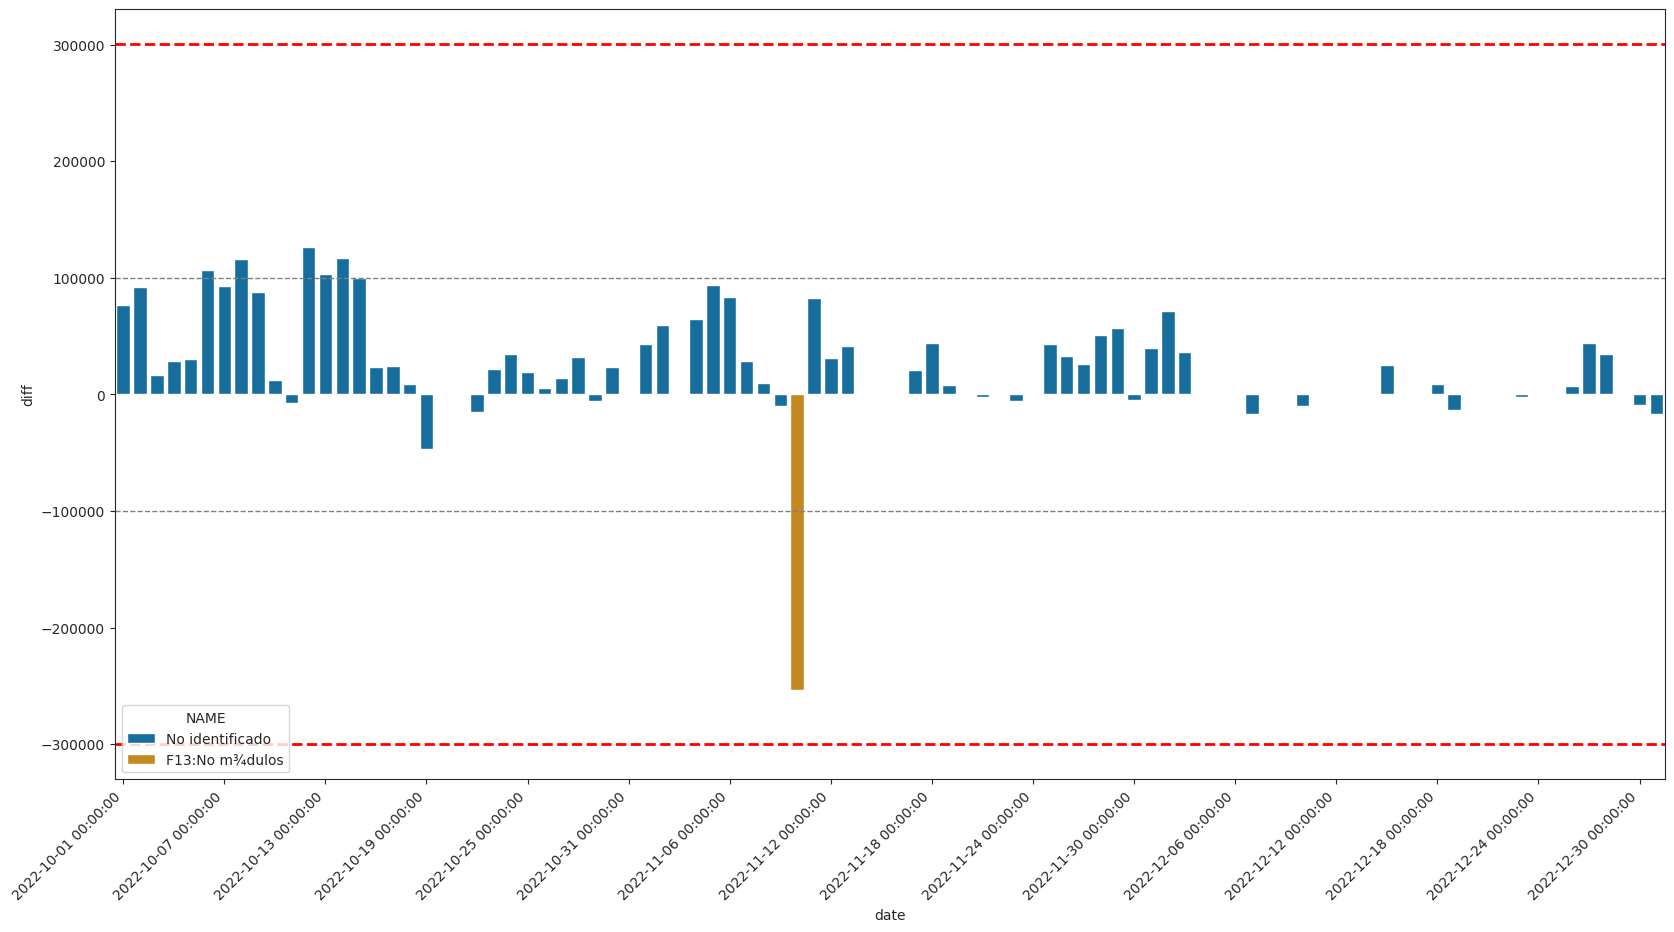

In [25]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 10) |
                               (daily_fallos_df["datetime_utc"].dt.month == 11) |
                               (daily_fallos_df["datetime_utc"].dt.month == 12)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2022)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

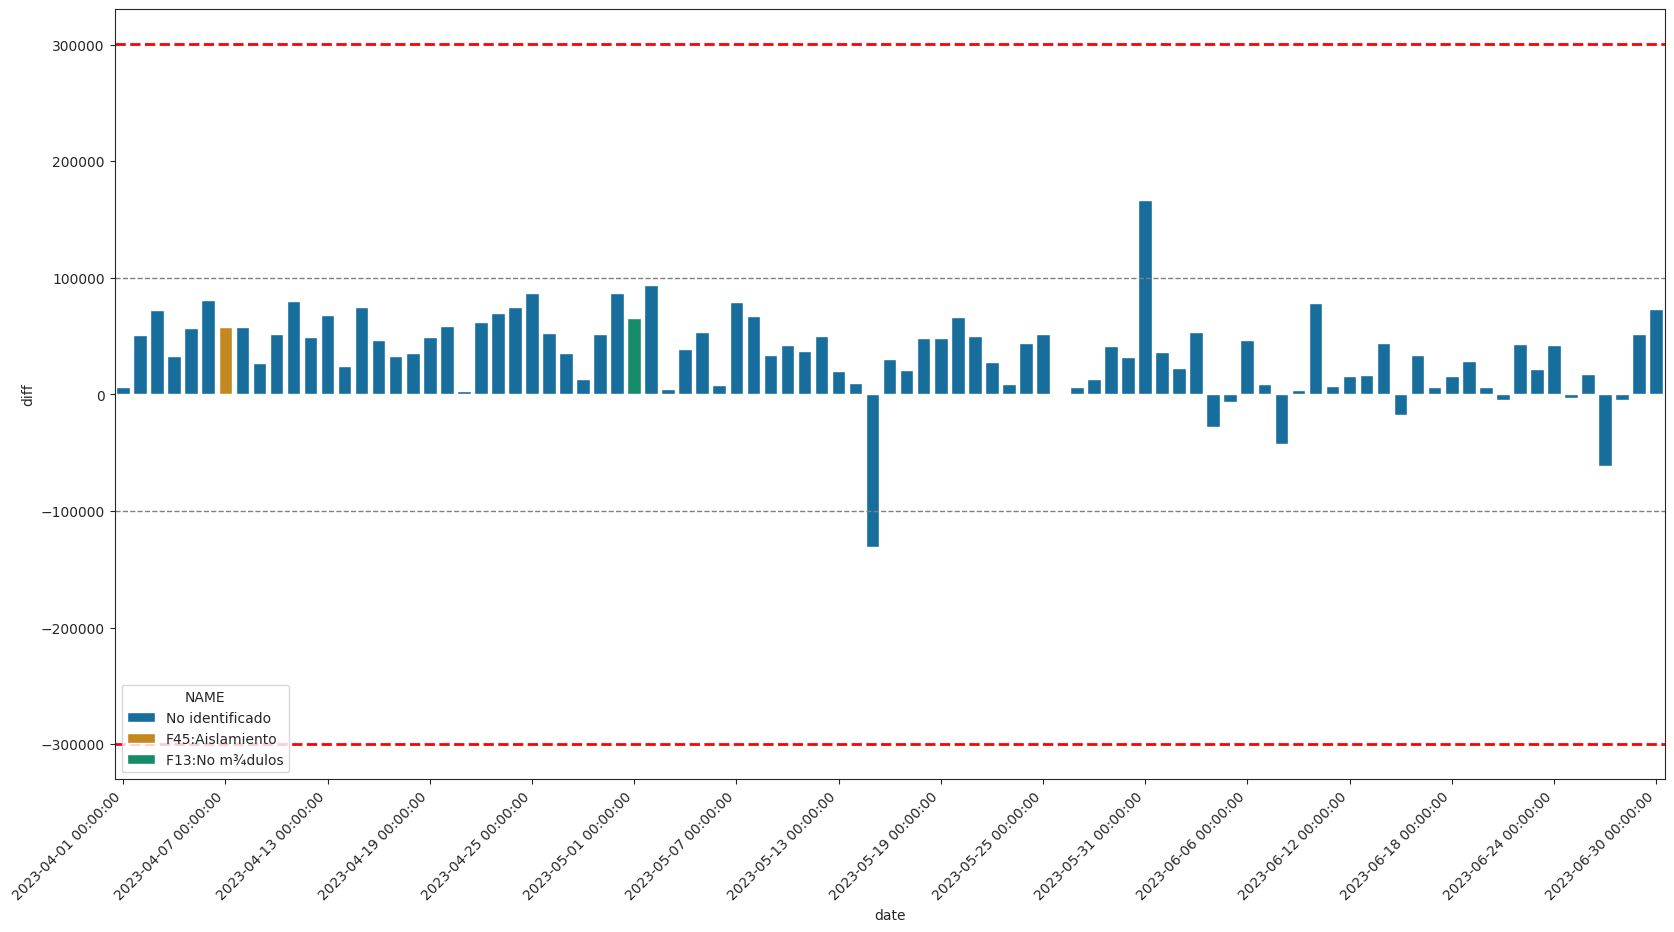

In [26]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 4) |
                               (daily_fallos_df["datetime_utc"].dt.month == 5) |
                               (daily_fallos_df["datetime_utc"].dt.month == 6)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2023)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

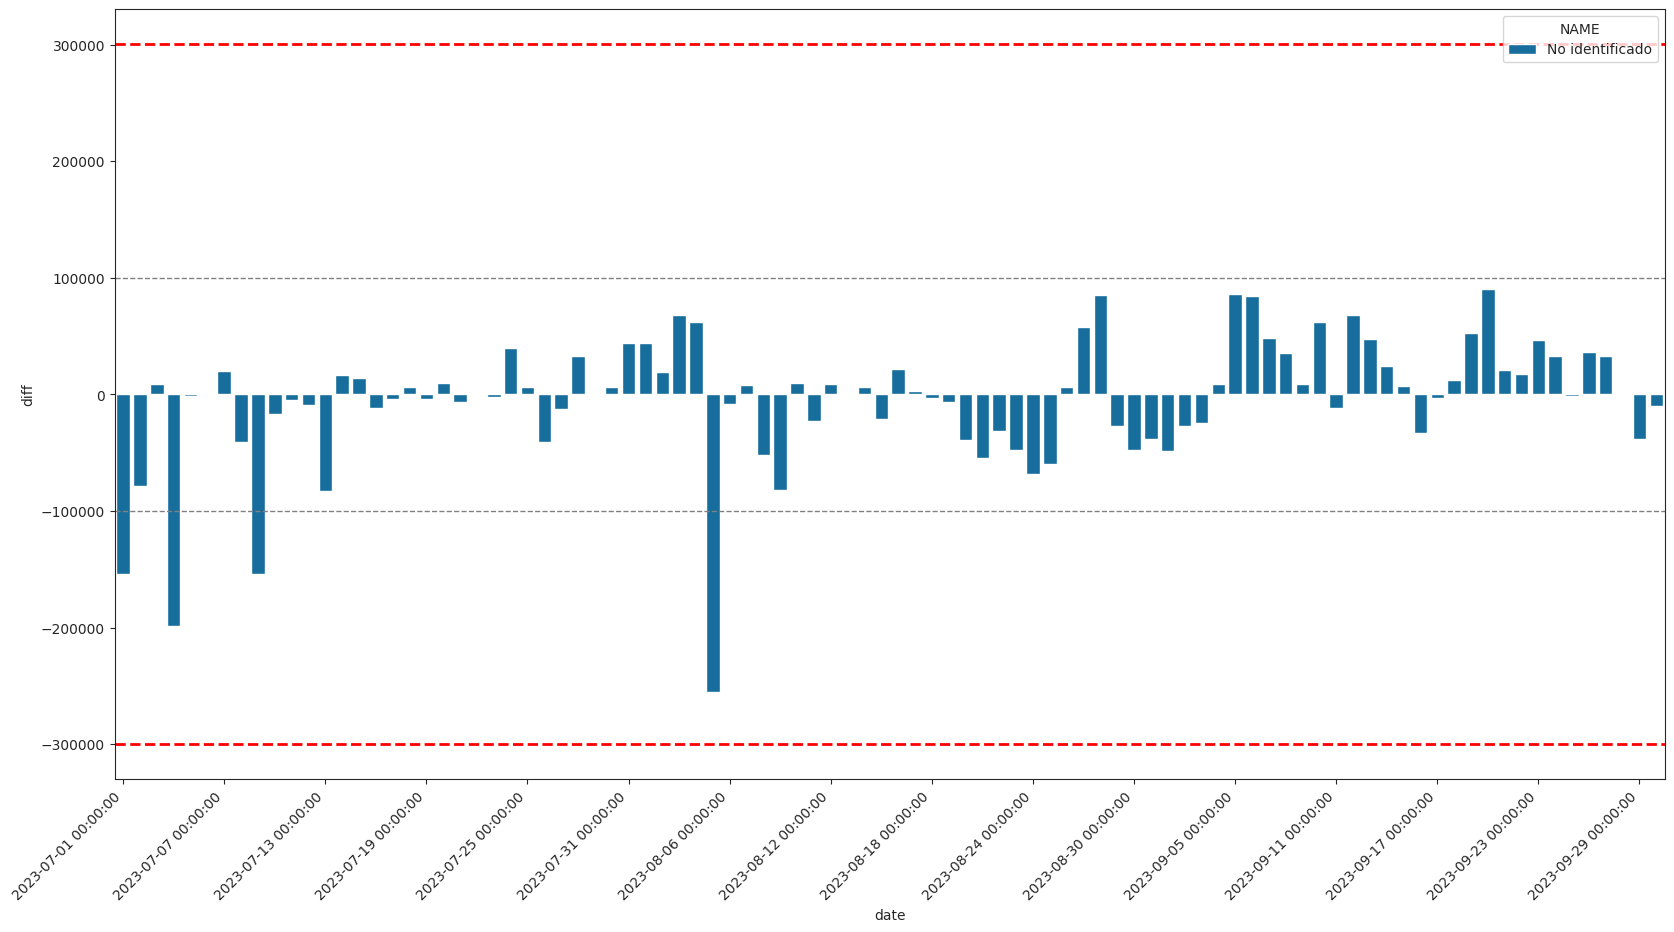

In [27]:
import seaborn as sns

# Set the style to have a smooth vertical grid
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(20, 10))
daily_fallos_df["NAME"] = daily_fallos_df["NAME"].fillna("No identificado")
filtered_df = daily_fallos_df[((daily_fallos_df["datetime_utc"].dt.month == 7) |
                               (daily_fallos_df["datetime_utc"].dt.month == 8) |
                               (daily_fallos_df["datetime_utc"].dt.month == 9)) &
                             (daily_fallos_df["datetime_utc"].dt.year == 2023)].drop_duplicates(subset = ["date", "NAME"])
sns.barplot(filtered_df, 
            x="date", 
            y="diff", 
            hue="NAME",
            ax=ax,
            dodge = False,
            palette = "colorblind")

# Set the x-axis labels to display every week
ax.xaxis.set_major_locator(plt.MaxNLocator(filtered_df.shape[0]//5))
plt.xticks(rotation=45, ha='right')

# Add horizontal dashed lines at +- lower_lim
ax.axhline(y=-lower_lim, linestyle='--', color='gray', linewidth=1)
ax.axhline(y=lower_lim, linestyle='--', color='gray', linewidth=1)

# Add thicker red dashed lines at +- upper_lim
ax.axhline(y=-upper_lim, linestyle='--', color='red', linewidth=2)
ax.axhline(y=upper_lim, linestyle='--', color='red', linewidth=2)

plt.show()

In [28]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import json
import pickle
import os
import sys
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from functools import partial
from sklearn.metrics import mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
import time
import gc

def objective(space, train_set, cv_folds):
    n_estimators = int(space.pop('n_estimators'))
    params = {'device': device,
            'objective': 'reg:squarederror',
            'tree_method': "hist",
            'random_state': 42,
            'n_jobs': -1}
    params = {**params, **space}
    if 'max_depth' in params:
        params['max_depth'] = int(params['max_depth'])
    if 'min_child_weight' in params:
        params['min_child_weight'] = max(1, int(params['min_child_weight']))

    cv_results = xgb.cv(params, train_set, nfold = cv_folds, num_boost_round = n_estimators, early_stopping_rounds = 100, metrics = 'rmse', as_pandas = True)
    return {'loss': cv_results['test-rmse-mean'].min(), 'status': STATUS_OK}

def discriminador(row):
    mean = np.mean(row)
    std = np.std(row)
    threshold = 3 * std
    outlier = np.abs(row - mean) > threshold
    return outlier

def optimize_hyperparameters(space, dtrain, STALL_LIMIT = 5, MAX_EVALS_PER_RUN = 250, gamma_algo = 0.75, cv_folds = 5, verbose = False):
    best_loss = np.inf
    trials = Trials()
    stall_counter = 0
    num_evals = 0
    upper_limit = (MAX_EVALS_PER_RUN * (STALL_LIMIT - 1)) * 10

    while stall_counter < STALL_LIMIT and num_evals < upper_limit:
        best = fmin(fn=lambda space: objective(space, train_set=dtrain, cv_folds=cv_folds), 
                    space=space, 
                    algo=partial(tpe.suggest, gamma=gamma_algo),
                    max_evals=num_evals + MAX_EVALS_PER_RUN, 
                    trials=trials,
                    verbose=verbose)
        best_params = space_eval(space, best)
        new_loss = trials.best_trial['result']['loss']
        if new_loss < best_loss:
            best_loss = new_loss
            stall_counter = 0
        else:
            stall_counter += 1
        num_evals += MAX_EVALS_PER_RUN
        gamma_algo = max(0.25, gamma_algo - 0.05)

    print(f"\tNúmero de evaluaciones realizadas: {num_evals}")
    print(f"\tBest params: {best_params}")
    print(f"\tBest loss: {best_loss}", end="\n\n")

    return best_params

print("Configuración para el entrenamiento de modelos de predicción de potencia activa de salida en inversores fotovoltaicos:", end="\n\n")
model_name = "XGBRegressor"

valid_responses = ["y", "n"]
normalizacion = ""
while normalizacion not in valid_responses:
    normalizacion = input("¿Desea normalizar el target? (Y/N): ").lower()
normalizacion = normalizacion == "y"

optimizacion = ""
while optimizacion not in valid_responses:
    optimizacion = input("¿Desea optimizar el modelo? (Y/N): ").lower()
optimizacion = optimizacion == "y"

stage = True
valid_devices = ["cpu", "cuda"]
device = ""
if optimizacion:
    while stage not in valid_responses:
        stage = input("\t¿Desea optimizar por fases? (Y/N): ").lower()
    stage = stage == "y"
    # Comprobación de la disponibilidad de GPU para el entrenamiento
    if torch.cuda.is_available():
        while device not in valid_devices:
            device_bool = input("¿Desea utilizar GPU para el entrenamiento? (Y/N): ").lower()
            if device_bool == "y":
                device = "cuda"
            else:
                device = "cpu"
else:
    stage = False
    device = 'cpu'

print(f"\nLas opciones seleccionadas son: \nModelo: {model_name} \nNormalización: {normalizacion} \nOptimización: {optimizacion} \nEntrenamiento: {device}", end="\n\n")

root_path = "/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo"
params = None
for filename in os.listdir(root_path):
    if "params.json" in filename:
        with open(os.path.join(root_path, filename)) as f:
            params = json.load(f)
if params is None:
    print("No se ha encontrado el archivo de parámetros para la conexión a la base de datos")
    sys.exit()
data_path = os.path.join(root_path, params["data_path"])
schema_name = params["schema"]

password = params['password'].replace('@', '%40')
engine = create_engine(f'postgresql://{params["user"]}:{password}@{params["host"]}:{params["port"]}/{params["dbname"]}')
print(f"Conexión a la base de datos {params['dbname']} (esquema {schema_name}) establecida")

intervalo_min = 30
num_mod_string = 30
sup_mod = 2
# Carga de los datos de entrenamiento
main_query = f"""
            WITH inv AS (
                SELECT 
                    inv.id,
                    datetime_utc,
                    dispositivo_id,
                    det.entrada_id,
                    potencia_act, 
                    amp_dc
                FROM {schema_name}.inversores AS inv
                JOIN {schema_name}.inversores_detalle AS det
                    ON inv.id = det.id
                WHERE (EXTRACT(MINUTE FROM datetime_utc) %% 5 = 0)
                    AND (EXTRACT(SECOND FROM datetime_utc) = 0)
                    AND (dispositivo_id != 26)
                    AND (alarma = 0)
                    AND (estado = 6)
                ),
            met AS (
                SELECT 
                    datetime_utc, 
                    dispositivo_id,
                    rad_poa, 
                    rad_hor, 
                    rad_celda1,
                    rad_celda2, 
                    temp_amb, 
                    temp_panel1,
                    temp_panel2, 
                    cloud_impact,
                    daylight
                FROM {schema_name}.meteo
                    WHERE daylight = true
                )
            SELECT 
                inv.id,
                inv.dispositivo_id,
                inv.entrada_id,
                inv.datetime_utc, 
                potencia_act,  
                num_strings, 
                rad_poa,
                rad_hor, 
                rad_celda1, 
                rad_celda2, 
                temp_amb, 
                temp_panel1, 
                temp_panel2,
                cloud_impact,
                motivo,
                consigna_pot_act_planta,
                amp_dc
            FROM inv
            JOIN {schema_name}.distrib_inversores dist
                ON dist.dispositivo_id = inv.dispositivo_id
                    AND dist.entrada_id = inv.entrada_id
            JOIN {schema_name}.dispositivos AS disp
                ON disp.dispositivo_id = inv.dispositivo_id
            JOIN met
                ON met.datetime_utc = inv.datetime_utc
                    AND met.dispositivo_id = disp.meteo_cercana_id
            JOIN {schema_name}.ree AS ree
                ON ree.datetime_utc = inv.datetime_utc
            ORDER BY 5, 2, 3, 4;"""

chunksize = 100000
chunks = pd.read_sql_query(main_query, engine, chunksize=chunksize)
main_df = pd.DataFrame()
for chunk in chunks:
    main_df = pd.concat([main_df, chunk], ignore_index = True)

# Normalización de la entrada de corriente continua, formateo de fechas y escalado de potencia
print(f"Carga inicial de {main_df.shape[0]} registros")
if normalizacion:
    print("Entrada de corriente continua normalizada según el número de strings")
    main_df["amp_dc"] = main_df["amp_dc"]/main_df["num_strings"]
else:
    print("Entrada de corriente continua sin normalizar")
main_df["datetime_utc"] = pd.to_datetime(main_df["datetime_utc"], utc = True)
main_df["potencia_act"] = main_df["potencia_act"] * 1000

# Pivotado de las entradas de corriente continua
target_df = main_df.pivot(index=["dispositivo_id", "datetime_utc"], columns='entrada_id', values='amp_dc')
target_df.columns = ["amp_dc_" + str(col) for col in target_df.columns]
print(f"Número de registros del dataframe tras pivotar: {target_df.shape[0]}")

# Descarte de registros con corriente anómala
target_df["outlier"] = target_df.apply(discriminador, axis=1).any(axis=1)
n_corriente_outlier = target_df[target_df["outlier"]].shape[0]
target_df = target_df[~target_df["outlier"]].drop(columns="outlier")
print(f"Registros descartados por corrientes anómalas ingresando en el inversor: {n_corriente_outlier}")

# Rellenado de valores faltantes por desconexión de entradas
consulta_sql = f"""SELECT MAX(entrada_id)
            FROM {schema_name}.distrib_inversores;"""
max_entradas = pd.read_sql_query(consulta_sql, engine).values[0][0]
entradas = [i for i in range(1, max_entradas + 1)]
for dispositivo in target_df.index.get_level_values(0).unique():
    consulta_sql = f"""SELECT entrada_id
                FROM {schema_name}.distrib_inversores
                WHERE dispositivo_id = {dispositivo};"""
    entradas_inv = pd.read_sql_query(consulta_sql, engine).values.reshape(1,-1)[0]
    entradas_off = list(set(entradas) - set(entradas_inv))
    for entrada in entradas_off:
        target_df.loc[dispositivo, "amp_dc_" + str(entrada)] = 0

# Descarte de registros con corriente desconocida
n_nan_values = target_df[target_df.isna().any(axis=1)].shape[0]
target_df = target_df.dropna()
print(f"Registros descartados por corriente desconocida: {n_nan_values}")

# Descarte de registros con corriente negativa
q1 = main_df[main_df['amp_dc'] < 0]['amp_dc'].quantile(0.25)
q3 = main_df[main_df['amp_dc'] < 0]['amp_dc'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
n_corriente_neg = target_df[target_df < lower_bound].dropna(how='all').shape[0]
target_df = target_df[target_df >= lower_bound].dropna(how='any')
target_df[(target_df >= lower_bound) & (target_df <= 0)] = 0
main_df = main_df.drop(columns=["entrada_id", "amp_dc"]).drop_duplicates(subset=["id", "datetime_utc"]).set_index(["dispositivo_id", "datetime_utc"])
main_df = main_df.merge(target_df, left_index=True, right_index=True, how="inner")
del target_df
gc.collect()
print(f"Registros descartados por corriente negativa: {n_corriente_neg}")

# Búsqueda de outliers basándose en la potencia activa y la potencia solar
num_strings_inv = f"""SELECT dispositivo_id, SUM(num_strings) as num_strings 
                        FROM {schema_name}.distrib_inversores
                        GROUP BY dispositivo_id;"""
num_strings_inv = pd.read_sql_query(num_strings_inv, engine).sort_values(by="dispositivo_id")
potencia_df = pd.merge(main_df.reset_index()[["dispositivo_id", "datetime_utc", "potencia_act", "rad_poa"]], num_strings_inv, on="dispositivo_id").set_index(["dispositivo_id", "datetime_utc"])
potencia_df["potencia_solar"] = potencia_df["rad_poa"] * potencia_df["num_strings"] * num_mod_string * sup_mod
potencia_df["outlier_solar"] = np.where(potencia_df["potencia_act"] > 0.20 * potencia_df["potencia_solar"], True, False)
main_df = main_df.merge(potencia_df[["outlier_solar"]], left_index=True, right_index=True, how="inner")
print(f"Registros descartados por outlier de potencia: {main_df[main_df['outlier_solar'] == True].shape[0]}")
main_df = main_df[main_df["outlier_solar"] == False].drop(columns = ["outlier_solar"])
del potencia_df, num_strings_inv
gc.collect()

# Descarte de registros con potencia activa negativa
n_potencia_neg = main_df[main_df["potencia_act"] < 0].shape[0]
main_df = main_df[main_df["potencia_act"] >= 0]
print(f"Registros descartados por potencia activa negativa: {n_potencia_neg}")





Configuración para el entrenamiento de modelos de predicción de potencia activa de salida en inversores fotovoltaicos:


Las opciones seleccionadas son: 
Modelo: XGBRegressor 
Normalización: True 
Optimización: False 
Entrenamiento: cpu

Conexión a la base de datos fvpredictive (esquema galisteo) establecida
Carga inicial de 13634096 registros
Entrada de corriente continua normalizada según el número de strings
Número de registros del dataframe tras pivotar: 852131
Registros descartados por corrientes anómalas ingresando en el inversor: 135559
Registros descartados por corriente desconocida: 0
Registros descartados por corriente negativa: 693
Registros descartados por outlier de potencia: 10387
Registros descartados por potencia activa negativa: 60


In [29]:
main_copy = main_df.copy()

In [30]:
from scipy import stats
main_df = main_copy.copy()
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"])

q1_neg = main_df[main_df["rad_diff"] < 0]["rad_diff"].quantile(0.25)
q3_neg = main_df[main_df["rad_diff"] < 0]["rad_diff"].quantile(0.75)
iqr_neg = q3_neg - q1_neg

# Define the lower and upper bounds for the anomalous values
neg_lower_bound = q1_neg - 1.5 * iqr_neg

q1_pos = main_df[main_df["rad_diff"] >= 0]["rad_diff"].quantile(0.25)
q3_pos = main_df[main_df["rad_diff"] >= 0]["rad_diff"].quantile(0.75)
iqr_pos = q3_pos - q1_pos

# Define the lower and upper bounds for the anomalous values
pos_upper_bound = q3_pos + 3 * iqr_pos

print(f"Lower bound: {neg_lower_bound}"
      f"\nUpper bound: {pos_upper_bound}")


# Calculate the z-scores for the "rad_diff" column
mean_rad_diff = main_df["rad_diff"].mean()
std_rad_diff = main_df["rad_diff"].std()

print(mean_rad_diff - std_rad_diff, mean_rad_diff + 6 * std_rad_diff)

main_df["rad_diff"] = main_df["rad_diff"] / main_df["rad_celda1"]

q1_neg = main_df[main_df["rad_diff"] < 0]["rad_diff"].quantile(0.25)
q3_neg = main_df[main_df["rad_diff"] < 0]["rad_diff"].quantile(0.75)
iqr_neg = q3_neg - q1_neg

# Define the lower and upper bounds for the anomalous values
neg_lower_bound = q1_neg - 1.5 * iqr_neg

q1_pos = main_df[main_df["rad_diff"] >= 0]["rad_diff"].quantile(0.25)
q3_pos = main_df[main_df["rad_diff"] >= 0]["rad_diff"].quantile(0.75)
iqr_pos = q3_pos - q1_pos

# Define the lower and upper bounds for the anomalous values
pos_upper_bound = q3_pos + 3 * iqr_pos

print(f"Lower bound: {neg_lower_bound}"
      f"\nUpper bound: {pos_upper_bound}")


# Calculate the z-scores for the "rad_diff" column
mean_rad_diff = main_df["rad_diff"].mean()
std_rad_diff = main_df["rad_diff"].std()

print(mean_rad_diff - 3 * std_rad_diff, mean_rad_diff + 6 * std_rad_diff)






Lower bound: -6.199999999999875
Upper bound: 49.000000000000014
-3.066244705976075 79.35529251941603
Lower bound: -0.025847699996253765
Upper bound: 0.07886104505822815
-0.0697425350306539 0.18370452393267392


In [31]:
main_df[(main_df["rad_diff"] < -0.07)]

id  potencia_act  num_strings  \
dispositivo_id datetime_utc                                                     
24             2023-04-17 06:00:00+00:00    598371             0           24   
30             2022-09-05 06:00:00+00:00  16050402             0           24   
33             2022-01-22 07:40:00+00:00   7629097             0           21   
               2022-02-09 07:25:00+00:00   8302627             0           21   
               2022-02-14 18:00:00+00:00   8506337             0           21   
...                                            ...           ...          ...   
21             2023-09-26 08:20:00+00:00   6659790       2736000           24   
23             2022-06-21 09:15:00+00:00  13213158       2954000           24   
25             2022-06-21 09:15:00+00:00  13213160       2954000           21   
24             2022-06-21 09:15:00+00:00  13213159       2957000           24   
21             2022-06-21 09:15:00+00:00  13213156       3137000           24   

                                          rad_poa  rad_hor  rad_celda1  \
dispositivo_id datetime_utc                                              
24             2023-04-17 06:00:00+00:00     24.6     19.6        20.0   
30             2022-09-05 06:00:00+00:00      6.5      6.7         6.5   
33             2022-01-22 07:40:00+00:00      4.2      4.2         2.7   
               2022-02-09 07:25:00+00:00      6.2      6.4         1.7   
               2022-02-14 18:00:00+00:00      5.8      5.8         5.9   
...                                           ...      ...         ...   
21             2023-09-26 08:20:00+00:00    826.2    379.0       742.1   
23             2022-06-21 09:15:00+00:00   1043.1    748.4       898.0   
25             2022-06-21 09:15:00+00:00   1043.1    748.4       898.0   
24             2022-06-21 09:15:00+00:00   1043.1    748.4       898.0   
21             2022-06-21 09:15:00+00:00   1043.1    748.4       898.0   

                                          rad_celda2  temp_amb  temp_panel1  \
dispositivo_id datetime_utc                                                   
24             2023-04-17 06:00:00+00:00        21.7      12.9         11.4   
30             2022-09-05 06:00:00+00:00         8.8      16.3          9.9   
33             2022-01-22 07:40:00+00:00         3.0       1.0         -1.4   
               2022-02-09 07:25:00+00:00         2.6       4.7          2.1   
               2022-02-14 18:00:00+00:00         7.6      11.7          8.3   
...                                              ...       ...          ...   
21             2023-09-26 08:20:00+00:00       822.0      21.3         39.4   
23             2022-06-21 09:15:00+00:00       992.0      19.5         41.7   
25             2022-06-21 09:15:00+00:00       992.0      19.5         41.7   
24             2022-06-21 09:15:00+00:00       992.0      19.5         41.7   
21             2022-06-21 09:15:00+00:00       992.0      19.5         41.7   

                                          temp_panel2  ...  amp_dc_8  \
dispositivo_id datetime_utc                            ...             
24             2023-04-17 06:00:00+00:00         10.8  ...  0.129167   
30             2022-09-05 06:00:00+00:00          9.7  ...  0.054167   
33             2022-01-22 07:40:00+00:00         -1.4  ...  0.037500   
               2022-02-09 07:25:00+00:00          2.1  ...  0.008333   
               2022-02-14 18:00:00+00:00          8.3  ...  0.008333   
...                                               ...  ...       ...   
21             2023-09-26 08:20:00+00:00         39.4  ...  6.975000   
23             2022-06-21 09:15:00+00:00         42.9  ...  7.316667   
25             2022-06-21 09:15:00+00:00         42.9  ...  7.508333   
24             2022-06-21 09:15:00+00:00         42.9  ...  7.658333   
21             2022-06-21 09:15:00+00:00         42.9  ...  7.954167   

                                          amp_dc_9  amp_dc_10  amp

In [32]:
main_df = main_copy.copy()
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"]) / main_df["rad_celda1"]
# Calculate the IQR for rad_diff
q1 = main_df[main_df["rad_diff"] >= 0]["rad_diff"].quantile(0.25)
q3 = main_df[main_df["rad_diff"] >= 0]["rad_diff"].quantile(0.75)
iqr = q3 - q1

# Define the lower and upper bounds for the anomalous values
lower_bound = q1 - 1.5 * iqr


# Discard the anomalous values and set the rest to zero
anomalous_values = main_df[(main_df["rad_diff"] < lower_bound) & (main_df["rad_diff"] < 0)]["rad_diff"]
normal_values = main_df[(main_df["rad_diff"] >= lower_bound) | (main_df["rad_diff"] >= 0)]["rad_diff"]
#main_df.loc[main_df["rad_diff"] < lower_bound, "rad_diff"] = 0

# Print the ranges of anomalous and normal values
print(lower_bound, upper_bound)


NameError: name 'upper_bound' is not defined

In [ ]:
main_df[main_df["rad_diff"] < 0]["rad_diff"].describe()

In [ ]:
# Manipulación de variables meteorológicas
main_df = main_copy.copy()
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"]) #/ (main_df["rad_celda1"] + 1)
mean_rad_diff = main_df["rad_diff"].mean()
std_rad_diff = main_df["rad_diff"].std()
main_df = main_df[(main_df["rad_diff"] >= mean_rad_diff - std_rad_diff) & (main_df["rad_diff"] <= mean_rad_diff + 6 * std_rad_diff)]
main_df["rad_diff"] = main_df["rad_diff"] / main_df["rad_celda1"]

main_df["temp_amb"] = main_df["temp_amb"] + 273.15
main_df["temp_panel1"] = main_df["temp_panel1"] + 273.15
main_df["temp_panel2"] = main_df["temp_panel2"] + 273.15
main_df["temp_panel"] = ((main_df["temp_panel1"] + main_df["temp_panel2"]) / 2) / ((main_df["rad_poa"] + 1))
main_df = main_df.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

sns.heatmap(main_df[["rad_poa", "temp_amb", "temp_panel", "rad_diff", "potencia_act"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")

Configuración para el entrenamiento de modelos de predicción de potencia activa de salida en inversores fotovoltaicos:




Las opciones seleccionadas son: 
Modelo: XGBRegressor 
Normalización: True 
Optimización: False 
Entrenamiento: cpu

Conexión a la base de datos fvpredictive (esquema galisteo) establecida
Carga inicial de 13634096 registros
Entrada de corriente continua normalizada según el número de strings
Número de registros del dataframe tras pivotar: 852131
Registros descartados por corrientes anómalas ingresando en el inversor: 135559
Registros descartados por corriente desconocida: 0
Registros descartados por corriente negativa: 693
Registros descartados por outlier de potencia: 10387
Registros descartados por potencia activa negativa: 60
Dispositivo 21
	Registros de entrenamiento: 49190
	Registros de validación: 12298
RMSE: 188139.038
MAE: 77288.294
R2: 0.966
{'0-100': 19418.89, '100-250': 58674.05, '250-500': 140680.12, '500+': 227221.12}
{'normalizacion': True, 'optimizacion': False, 'por_fases': False, 'metricas': {'RMSE': 188139.038, 'MAE': 77288.294, 'R2': 0.966}, 'metricas_rad': {'0-100

KeyboardInterrupt: 

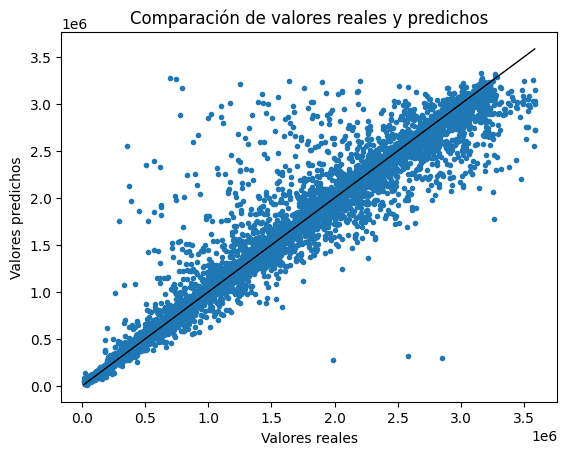

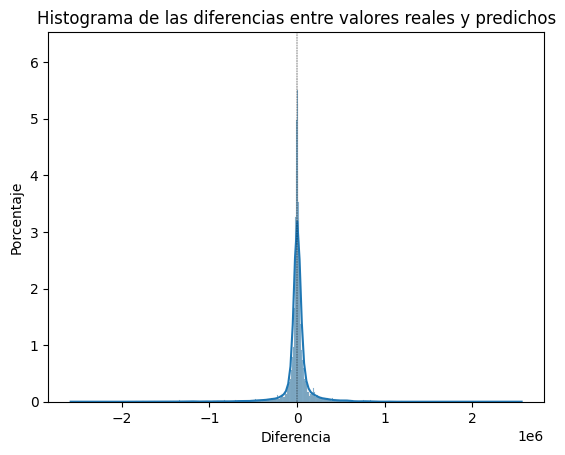

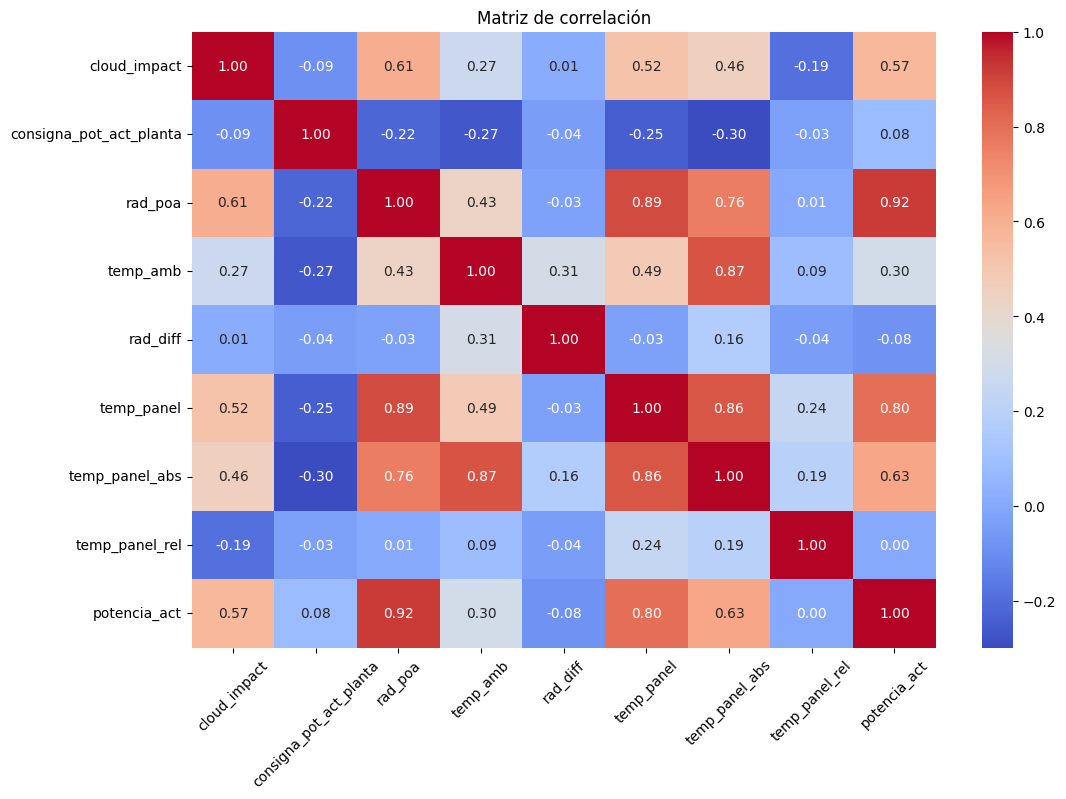

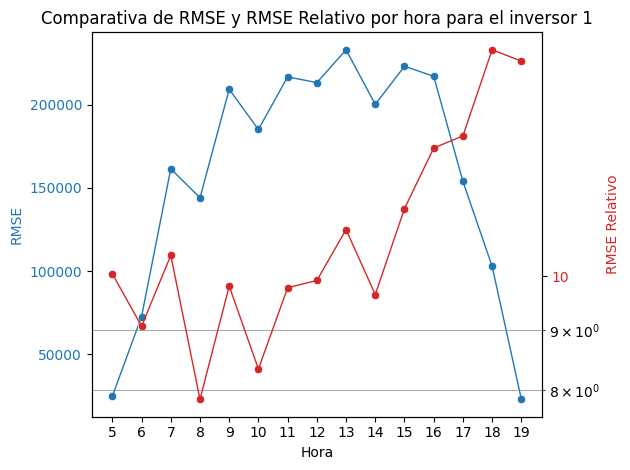

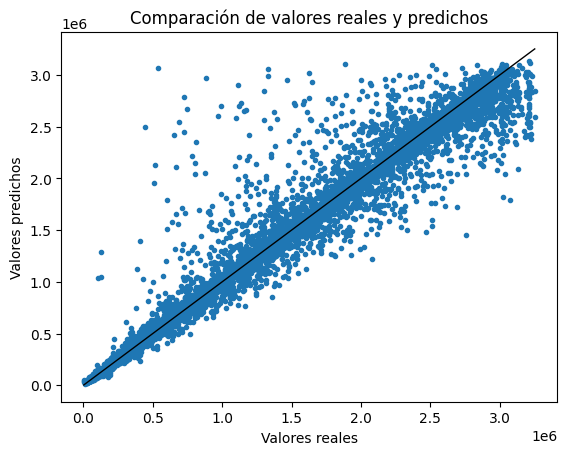

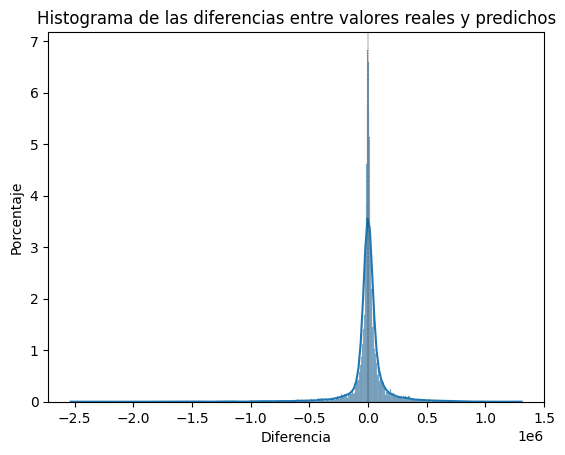

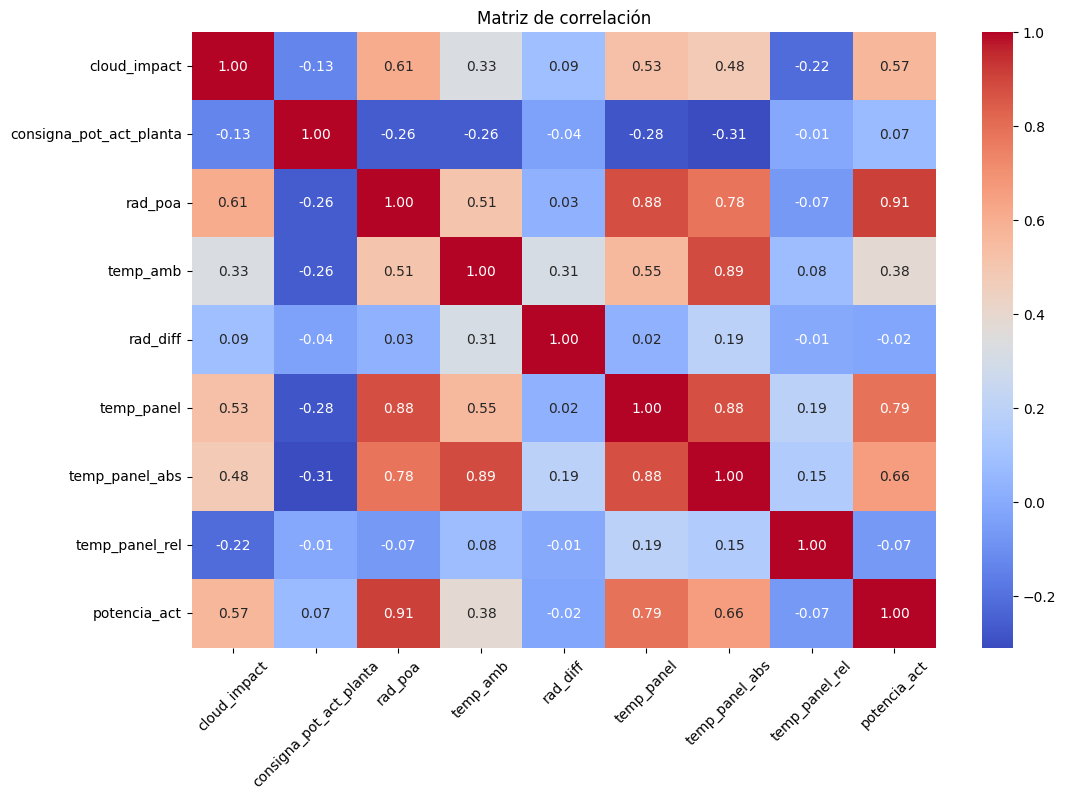

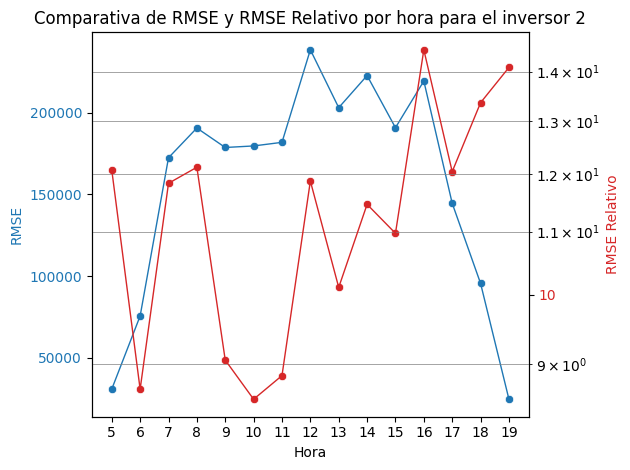

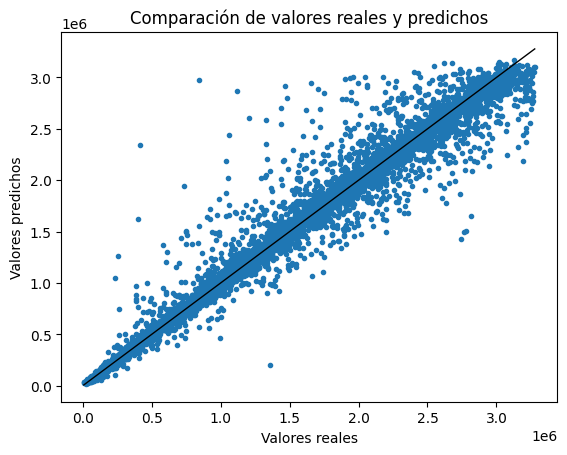

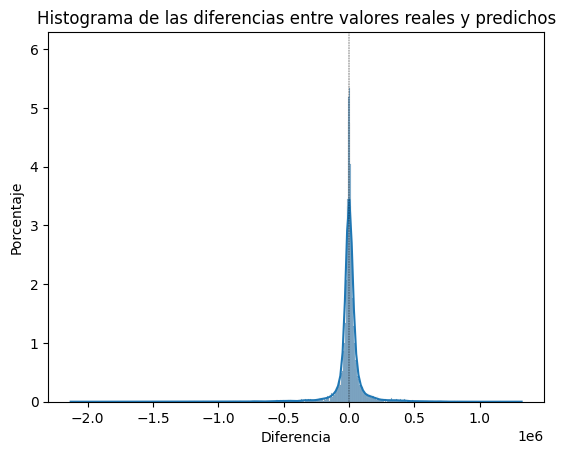

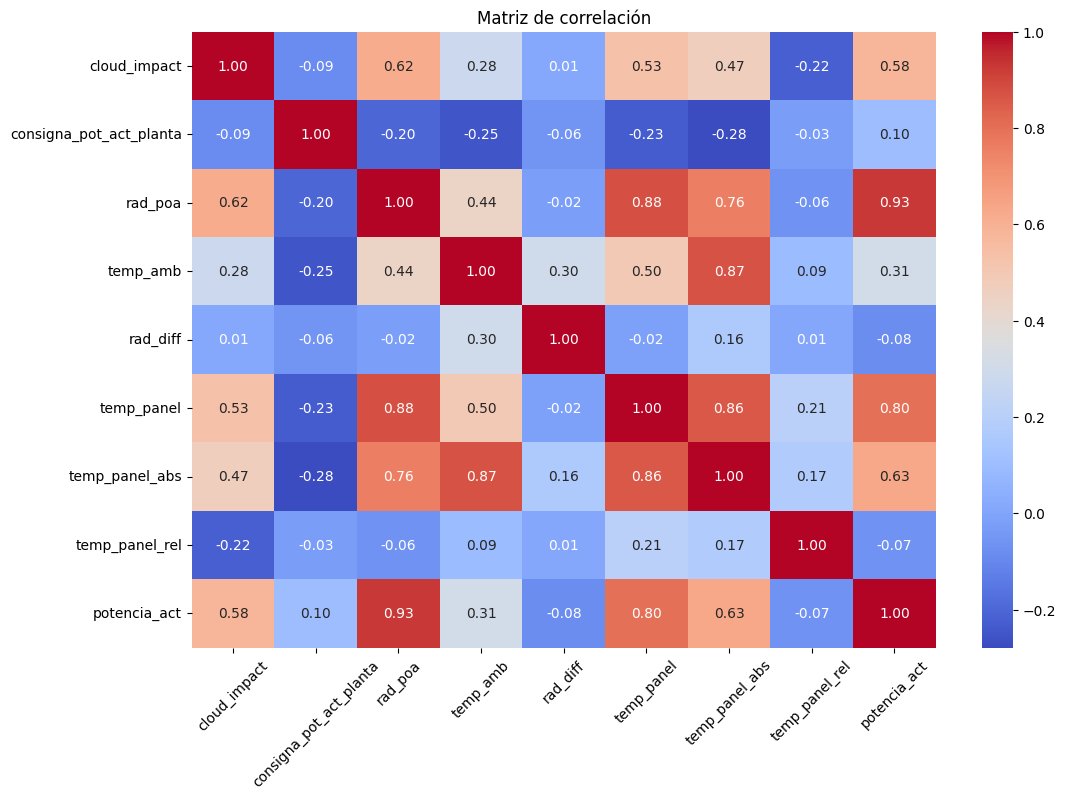

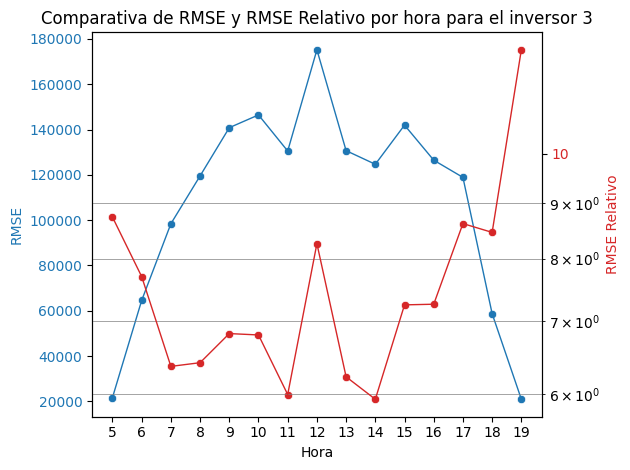

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import json
import pickle
import os
import sys
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from functools import partial
from sklearn.metrics import mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
import time
import gc


def discriminador(row):
    mean = np.mean(row)
    std = np.std(row)
    threshold = 3 * std
    outlier = np.abs(row - mean) > threshold
    return outlier

def objective(space, train_set, cv_folds):
    n_estimators = int(space.pop('n_estimators'))
    params = {'device': device,
            'objective': 'reg:squarederror',
            'tree_method': "hist",
            'random_state': 42,
            'n_jobs': -1}
    params = {**params, **space}
    if 'max_depth' in params:
        params['max_depth'] = int(params['max_depth'])
    if 'min_child_weight' in params:
        params['min_child_weight'] = max(1, int(params['min_child_weight']))

    cv_results = xgb.cv(params, train_set, nfold = cv_folds, num_boost_round = n_estimators, early_stopping_rounds = 100, metrics = 'rmse', as_pandas = True)
    return {'loss': cv_results['test-rmse-mean'].min(), 'status': STATUS_OK}

def optimize_hyperparameters(space, dtrain, STALL_LIMIT = 5, MAX_EVALS_PER_RUN = 250, gamma_algo = 0.75, cv_folds = 5, verbose = False):
    best_loss = np.inf
    trials = Trials()
    stall_counter = 0
    num_evals = 0
    upper_limit = (MAX_EVALS_PER_RUN * (STALL_LIMIT - 1)) * 10

    while stall_counter < STALL_LIMIT and num_evals < upper_limit:
        best = fmin(fn=lambda space: objective(space, train_set=dtrain, cv_folds=cv_folds), 
                    space=space, 
                    algo=partial(tpe.suggest, gamma=gamma_algo),
                    max_evals=num_evals + MAX_EVALS_PER_RUN, 
                    trials=trials,
                    verbose=verbose)
        best_params = space_eval(space, best)
        new_loss = trials.best_trial['result']['loss']
        if new_loss < best_loss:
            best_loss = new_loss
            stall_counter = 0
        else:
            stall_counter += 1
        num_evals += MAX_EVALS_PER_RUN
        gamma_algo = max(0.25, gamma_algo - 0.05)

    print(f"\tNúmero de evaluaciones realizadas: {num_evals}")
    print(f"\tBest params: {best_params}")
    print(f"\tBest loss: {best_loss}", end="\n\n")

    return best_params

print("Configuración para el entrenamiento de modelos de predicción de potencia activa de salida en inversores fotovoltaicos:", end="\n\n")
model_name = "XGBRegressor"

valid_responses = ["y", "n"]
normalizacion = ""
while normalizacion not in valid_responses:
    normalizacion = input("¿Desea normalizar el target? (Y/N): ").lower()
normalizacion = normalizacion == "y"

optimizacion = ""
while optimizacion not in valid_responses:
    optimizacion = input("¿Desea optimizar el modelo? (Y/N): ").lower()
optimizacion = optimizacion == "y"

stage = True
valid_devices = ["cpu", "cuda"]
device = ""
if optimizacion:
    while stage not in valid_responses:
        stage = input("\t¿Desea optimizar por fases? (Y/N): ").lower()
    stage = stage == "y"
    # Comprobación de la disponibilidad de GPU para el entrenamiento
    if torch.cuda.is_available():
        while device not in valid_devices:
            device_bool = input("¿Desea utilizar GPU para el entrenamiento? (Y/N): ").lower()
            if device_bool == "y":
                device = "cuda"
            else:
                device = "cpu"
    else:
        device = "cpu"
        print("No se ha detectado una GPU disponible, se utilizará la CPU para el entrenamiento")
else:
    stage = False
    device = 'cpu'

print(f"\nLas opciones seleccionadas son: \nModelo: {model_name} \nNormalización: {normalizacion} \nOptimización: {optimizacion} \nEntrenamiento: {device}", end="\n\n")

root_path = "/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo"
params = None
for filename in os.listdir(root_path):
    if "params.json" in filename:
        with open(os.path.join(root_path, filename, )) as f:
            params = json.load(f)
if params is None:
    print("No se ha encontrado el archivo de parámetros para la conexión a la base de datos")
    sys.exit()
data_path = os.path.join(root_path, params["data_path"])
schema_name = params["schema"]

password = params['password'].replace('@', '%40')
engine = create_engine(f'postgresql://{params["user"]}:{password}@{params["host"]}:{params["port"]}/{params["dbname"]}')
print(f"Conexión a la base de datos {params['dbname']} (esquema {schema_name}) establecida")

intervalo_min = 30
num_mod_string = 30
sup_mod = 2
# Carga de los datos de entrenamiento
main_query = f"""
            WITH inv AS (
                SELECT 
                    inv.id,
                    datetime_utc,
                    dispositivo_id,
                    det.entrada_id,
                    potencia_act, 
                    amp_dc
                FROM {schema_name}.inversores AS inv
                JOIN {schema_name}.inversores_detalle AS det
                    ON inv.id = det.id
                WHERE (EXTRACT(MINUTE FROM datetime_utc) %% 5 = 0)
                    AND (EXTRACT(SECOND FROM datetime_utc) = 0)
                    AND (dispositivo_id != 26)
                    AND (alarma = 0)
                    AND (estado = 6)
                ),
            met AS (
                SELECT 
                    datetime_utc, 
                    dispositivo_id,
                    rad_poa, 
                    rad_hor, 
                    rad_celda1,
                    rad_celda2, 
                    temp_amb, 
                    temp_panel1,
                    temp_panel2, 
                    cloud_impact,
                    daylight
                FROM {schema_name}.meteo
                    WHERE daylight = true
                )
            SELECT 
                inv.id,
                inv.dispositivo_id,
                inv.entrada_id,
                inv.datetime_utc, 
                potencia_act,  
                num_strings, 
                rad_poa,
                -- rad_hor, 
                rad_celda1, 
                rad_celda2, 
                temp_amb, 
                temp_panel1, 
                temp_panel2,
                cloud_impact,
                motivo,
                consigna_pot_act_planta,
                amp_dc
            FROM inv
            JOIN {schema_name}.distrib_inversores dist
                ON dist.dispositivo_id = inv.dispositivo_id
                    AND dist.entrada_id = inv.entrada_id
            JOIN {schema_name}.dispositivos AS disp
                ON disp.dispositivo_id = inv.dispositivo_id
            JOIN met
                ON met.datetime_utc = inv.datetime_utc
                    AND met.dispositivo_id = disp.meteo_cercana_id
            JOIN {schema_name}.ree AS ree
                ON ree.datetime_utc = inv.datetime_utc
            ORDER BY 5, 2, 3, 4;"""

chunksize = 100000
chunks = pd.read_sql_query(main_query, engine, chunksize=chunksize)
main_df = pd.DataFrame()
for chunk in chunks:
    main_df = pd.concat([main_df, chunk], ignore_index = True)

# Normalización de la entrada de corriente continua, formateo de fechas y escalado de potencia
print(f"Carga inicial de {main_df.shape[0]} registros")
if normalizacion:
    print("Entrada de corriente continua normalizada según el número de strings")
    main_df["amp_dc"] = main_df["amp_dc"]/main_df["num_strings"]
else:
    print("Entrada de corriente continua sin normalizar")
main_df["datetime_utc"] = pd.to_datetime(main_df["datetime_utc"], utc = True)
main_df["potencia_act"] = main_df["potencia_act"] * 1000

# Pivotado de las entradas de corriente continua
target_df = main_df.pivot(index=["dispositivo_id", "datetime_utc"], columns='entrada_id', values='amp_dc')
target_df.columns = ["amp_dc_" + str(col) for col in target_df.columns]
print(f"Número de registros del dataframe tras pivotar: {target_df.shape[0]}")

# Descarte de registros con corriente anómala
target_df["outlier"] = target_df.apply(discriminador, axis=1).any(axis=1)
n_corriente_outlier = target_df[target_df["outlier"]].shape[0]
target_df = target_df[~target_df["outlier"]].drop(columns="outlier")
print(f"Registros descartados por corrientes anómalas ingresando en el inversor: {n_corriente_outlier}")

# Rellenado de valores faltantes por desconexión de entradas
consulta_sql = f"""SELECT MAX(entrada_id)
            FROM {schema_name}.distrib_inversores;"""
max_entradas = pd.read_sql_query(consulta_sql, engine).values[0][0]
entradas = [i for i in range(1, max_entradas + 1)]
for dispositivo in target_df.index.get_level_values(0).unique():
    consulta_sql = f"""SELECT entrada_id
                FROM {schema_name}.distrib_inversores
                WHERE dispositivo_id = {dispositivo};"""
    entradas_inv = pd.read_sql_query(consulta_sql, engine).values.reshape(1,-1)[0]
    entradas_off = list(set(entradas) - set(entradas_inv))
    for entrada in entradas_off:
        target_df.loc[dispositivo, "amp_dc_" + str(entrada)] = 0

# Descarte de registros con corriente desconocida
n_nan_values = target_df[target_df.isna().any(axis=1)].shape[0]
target_df = target_df.dropna()
print(f"Registros descartados por corriente desconocida: {n_nan_values}")

# Descarte de registros con corriente negativa
q1 = main_df[main_df['amp_dc'] < 0]['amp_dc'].quantile(0.25)
q3 = main_df[main_df['amp_dc'] < 0]['amp_dc'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
n_corriente_neg = target_df[target_df < lower_bound].dropna(how='all').shape[0]
target_df = target_df[target_df >= lower_bound].dropna(how='any')
target_df[(target_df >= lower_bound) & (target_df <= 0)] = 0
main_df = main_df.drop(columns=["entrada_id", "amp_dc"]).drop_duplicates(subset=["id", "datetime_utc"]).set_index(["dispositivo_id", "datetime_utc"])
main_df = main_df.merge(target_df, left_index=True, right_index=True, how="inner")
del target_df
gc.collect()
print(f"Registros descartados por corriente negativa: {n_corriente_neg}")

# Búsqueda de outliers basándose en la potencia activa y la potencia solar
num_strings_inv = f"""SELECT dispositivo_id, SUM(num_strings) as num_strings 
                        FROM {schema_name}.distrib_inversores
                        GROUP BY dispositivo_id;"""
num_strings_inv = pd.read_sql_query(num_strings_inv, engine).sort_values(by="dispositivo_id")
potencia_df = pd.merge(main_df.reset_index()[["dispositivo_id", "datetime_utc", "potencia_act", "rad_poa"]], num_strings_inv, on="dispositivo_id").set_index(["dispositivo_id", "datetime_utc"])
potencia_df["potencia_solar"] = potencia_df["rad_poa"] * potencia_df["num_strings"] * num_mod_string * sup_mod
potencia_df["outlier_solar"] = np.where(potencia_df["potencia_act"] > 0.20 * potencia_df["potencia_solar"], True, False)
main_df = main_df.merge(potencia_df[["outlier_solar"]], left_index=True, right_index=True, how="inner")
print(f"Registros descartados por outlier de potencia: {main_df[main_df['outlier_solar'] == True].shape[0]}")
main_df = main_df[main_df["outlier_solar"] == False].drop(columns = ["outlier_solar"])
del potencia_df, num_strings_inv
gc.collect()

# Descarte de registros con potencia activa negativa
n_potencia_neg = main_df[main_df["potencia_act"] < 0].shape[0]
main_df = main_df[main_df["potencia_act"] >= 0]
print(f"Registros descartados por potencia activa negativa: {n_potencia_neg}")

# Manipulación de variables meteorológicas
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"]) #/ (main_df["rad_celda1"] + 1)
mean_rad_diff = main_df["rad_diff"].mean()
std_rad_diff = main_df["rad_diff"].std()
main_df = main_df[(main_df["rad_diff"] >= mean_rad_diff - std_rad_diff) & (main_df["rad_diff"] <= mean_rad_diff + 6 * std_rad_diff)]
main_df["rad_diff"] = main_df["rad_diff"] / (main_df["rad_celda1"] + 1)
main_df["temp_amb"] = main_df["temp_amb"] + 273.15
main_df["temp_panel1"] = main_df["temp_panel1"] + 273.15
main_df["temp_panel2"] = main_df["temp_panel2"] + 273.15
main_df["temp_panel_abs"] = (main_df["temp_panel1"] + main_df["temp_panel2"]) / 2
main_df["temp_panel"] = (((main_df["temp_panel1"] + main_df["temp_panel2"]) / 2) - main_df["temp_amb"]) #/ (main_df["rad_poa"] + 1)
main_df["temp_panel_rel"] = main_df["temp_panel"] / main_df["rad_poa"]
main_df = main_df.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

# Manipulación de variables de consigna
main_df["motivo"] = main_df["motivo"].apply(lambda x: 0 if x == 0 else (2 if x == 7 else 1))
main_query = f"""
    SELECT MAX(consigna_pot_act_planta)
        FROM {schema_name}.ree AS ree;"""
max_pot_act = pd.read_sql_query(main_query, engine).values[0][0]
main_df["consigna_pot_act_planta"] = main_df["consigna_pot_act_planta"] / max_pot_act   # Valor normalizado

# Asignación de variables temporales
main_df["dia_año"] = main_df.index.get_level_values("datetime_utc").dayofyear
main_df["dia_año_sen"] = np.sin(main_df["dia_año"] * (2*np.pi/365))
main_df["hora_seg"] = main_df.index.get_level_values("datetime_utc").hour * 3600 + \
                        main_df.index.get_level_values("datetime_utc").minute * 60 + \
                        main_df.index.get_level_values("datetime_utc").second
main_df["hora_seg_sen"] = np.sin(main_df["hora_seg"] * (2*np.pi/86400))

# Escalado de variables porcentuales
main_df[['cloud_impact']] = main_df[['cloud_impact']].apply(lambda x: x/100)

for inv_id in np.sort(main_df.index.get_level_values("dispositivo_id").unique()):
    # Separación de los datos de entrenamiento y validación
    print(f"Dispositivo {inv_id}")
    disp_df = main_df[main_df.index.get_level_values("dispositivo_id") == inv_id].copy()
    disp_df = disp_df.dropna()

    train_df, validation_df = train_test_split(disp_df, test_size = 0.2, random_state = 42)
    
    print(f"\tRegistros de entrenamiento: {train_df.shape[0]}")
    print(f"\tRegistros de validación: {validation_df.shape[0]}")

    # Separación de input y target
    y = train_df[["potencia_act"]].copy()
    y_val = validation_df[["potencia_act"]].copy()
    amp_columns = train_df.filter(like="amp_dc").columns.tolist()
    X = train_df.drop(columns = amp_columns+["id",
                                            "num_strings",
                                            "dia_año",
                                            "hora_seg",
                                            "potencia_act"
                                            ])
    X_val = validation_df.drop(columns = amp_columns+["id",
                                                    "num_strings",
                                                    "dia_año",
                                                    "hora_seg",
                                                    "potencia_act"
                                                    ])

    # Estandarización/normalización de variables numéricas y codificación de variables categóricas
    perc_attr = ['cloud_impact', 'consigna_pot_act_planta']
    std_attr = ['rad_poa', 'temp_amb', 'rad_diff', 'temp_panel', 'temp_panel_abs', 'temp_panel_rel']
    cat_attr = ['motivo']

    transformador_categorico = Pipeline([('onehot', OneHotEncoder(handle_unknown = 'ignore'))]) # Introducir manualmente catergorías?
    transformador_numerico_std = Pipeline([('std_scaler', StandardScaler())]) 

    preprocessor = ColumnTransformer(transformers=[('cat', transformador_categorico, cat_attr),
                                                ('std', transformador_numerico_std, std_attr)],
                                remainder='passthrough')
    X_prep = preprocessor.fit_transform(X)
    dtrain = xgb.DMatrix(X_prep, label=y)

    if optimizacion:
        start_time = time.time()
        if stage:
            print("\tOptimización del número de estimadores, learning rate, max_depth y min_child_weight")
            space = {'n_estimators': hp.quniform('n_estimators', 100, 1000, 5),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
                    'max_depth': hp.quniform("max_depth", 3, 15, 1),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 30, 1),
                    'gamma': 0,
                    'subsample': 0.8,
                    'reg_alpha': 0,
                    'reg_lambda': 0}
            best_params = optimize_hyperparameters(space, dtrain, STALL_LIMIT = 10, MAX_EVALS_PER_RUN = 250, cv_folds = 5)

            print("\tOptimización de gamma y subsample")
            space = {'max_depth': best_params['max_depth'],
                    'min_child_weight' : best_params['min_child_weight'],
                    'n_estimators': best_params['n_estimators'],
                    'learning_rate': best_params['learning_rate'],
                    'gamma': hp.uniform ('gamma', 0, 10),
                    'subsample': hp.uniform('subsample', 0.4, 1),
                    'reg_alpha': 0,
                    'reg_lambda': 0}
            best_params = optimize_hyperparameters(space, dtrain, STALL_LIMIT = 10, MAX_EVALS_PER_RUN = 50, cv_folds = 5)
                    
            print("\tRegularización")
            space = {'reg_alpha' : hp.uniform('reg_alpha', 0, 10),
                    'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
                    'n_estimators': best_params['n_estimators'],
                    'learning_rate': best_params['learning_rate'],
                    'max_depth': best_params['max_depth'],
                    'gamma': best_params['gamma'],
                    'min_child_weight': best_params['min_child_weight'],
                    'subsample': best_params['subsample']}
            best_params = optimize_hyperparameters(space, dtrain, STALL_LIMIT = 10, MAX_EVALS_PER_RUN = 50, cv_folds = 5)

            print(f"\tReoptimización de n_estimators y learning_rate con los parámetros finales")
            space = {'n_estimators': hp.quniform('n_estimators', 100, 2000, 5),
                    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
                    'max_depth': best_params['max_depth'],
                    'gamma': best_params['gamma'],
                    'min_child_weight': best_params['min_child_weight'],
                    'subsample': best_params['subsample'],
                    'reg_alpha': best_params['reg_alpha'],
                    'reg_lambda': best_params['reg_lambda']}
            best_params = optimize_hyperparameters(space, dtrain, STALL_LIMIT = 10, MAX_EVALS_PER_RUN = 75, cv_folds = 5)
        
        else:
            print("\tOptimización de los hiperparámetros")
            space = {'n_estimators': hp.quniform('n_estimators', 100, 1500, 5),
                    'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
                    'max_depth': hp.quniform("max_depth", 3, 15, 1),
                    'gamma': hp.uniform ('gamma', 0, 5),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 30, 1),
                    'subsample' : hp.uniform('subsample', 0.4, 1),
                    'reg_alpha' : hp.uniform('reg_alpha', 0, 10),
                    'reg_lambda' : hp.uniform('reg_lambda', 0, 10)}
            best_params = optimize_hyperparameters(space, dtrain, STALL_LIMIT = 5, MAX_EVALS_PER_RUN = 50, cv_folds = 5, verbose = True)
        end_time = time.time()
        execution_time = end_time - start_time
        execution_hours = int(execution_time // 3600)
        execution_minutes = int((execution_time % 3600) // 60)
        execution_seconds = int(execution_time % 60)
        print(f"Tiempo de ejecución: {execution_hours} horas, {execution_minutes} minutos y {execution_seconds} segundos")

        final_params = {"device": device,
                    "objective": 'reg:squarederror', 
                    "tree_method": "hist",
                    "random_state": 42,
                    "n_jobs": -1}
        final_params = {**final_params, **best_params}
        train_params = final_params.copy()
        final_params.pop('n_estimators')
        final_params['max_depth'] = int(final_params['max_depth'])
        final_params['min_child_weight'] = max(1, int(final_params['min_child_weight']))
        model = xgb.train(final_params, dtrain, num_boost_round = int(best_params['n_estimators']))
    else:
        train_params = {'device': device,
                'objective': 'reg:squarederror',
                'tree_method': "hist",
                'random_state': 42,
                'n_jobs': -1,
                'gamma': 3.9071783170189134, 
                'learning_rate': 0.014142328264137062, 
                'max_depth': 15, 
                'min_child_weight': 1,  
                'reg_alpha': 4.063160163005677, 
                'reg_lambda': 9.497743570405234, 
                'subsample': 0.6610672267306738}
        model = xgb.train(train_params, dtrain, num_boost_round=1900) 
    
    pipeline_model = Pipeline([('preprocessor', preprocessor),
                        ('regressor', model)])

    prediction_df = y_val.copy()
    dval = xgb.DMatrix(pipeline_model.named_steps['preprocessor'].transform(X_val))
    prediction_df["y_pred"] = pipeline_model.named_steps['regressor'].predict(dval)
    prediction_df["y_diff"] = prediction_df["potencia_act"] - prediction_df["y_pred"]

    rmse_score = round(mse(prediction_df["potencia_act"], prediction_df["y_pred"], squared = False),3)
    mae_score = round(mae(prediction_df["potencia_act"], prediction_df["y_pred"]),3)
    r2_score = round(r2(prediction_df["potencia_act"], prediction_df["y_pred"]),3)
    metricas = {"RMSE": rmse_score, "MAE": mae_score, "R2": r2_score}
    print(f"RMSE: {rmse_score}", 
            f"MAE: {mae_score}",
            f"R2: {r2_score}",
            sep = "\n")
    
    algoritmo = pipeline_model.named_steps["regressor"].__class__.__name__
    columnas = [col_name.split("__")[1] for col_name in preprocessor.get_feature_names_out()]
    importance_scores = model.get_score(importance_type='gain')
    total_gain = np.array([v for k,v in importance_scores.items()]).sum()
    importancia = {k: v/total_gain for k, v in importance_scores.items()}

    # Cálculo de RMSE por rangos de irradiancia
    rad_bins = [0, 100, 250, 500, np.inf]
    rad_labels = ["0-100", "100-250", "250-500", "500+"]
    prediction_df["rad_bin"] = pd.cut(validation_df["rad_poa"], bins = rad_bins, labels = rad_labels)
    rmse_rad = {}
    for group in prediction_df.groupby("rad_bin"):
        rmse_rad[group[0]] = round(mse(group[1]["potencia_act"], group[1]["y_pred"], squared=False), 2)
    print(rmse_rad)

    # Generación de gráficos: comparativa de valores reales y predichos, histograma de diferencias y matriz de correlación
    plt.figure()
    plt.tight_layout()
    plt.scatter(prediction_df["potencia_act"], prediction_df["y_pred"], marker = ".")
    plt.plot([min(prediction_df["potencia_act"]), max(prediction_df["potencia_act"])], [min(prediction_df["potencia_act"]), max(prediction_df["potencia_act"])], color='black', linestyle='-', linewidth=1)
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.title("Comparación de valores reales y predichos")

    plt.figure()
    plt.tight_layout()
    ax = sns.histplot(prediction_df["potencia_act"] - prediction_df["y_pred"], kde=True, stat='percent')
    ax.axvline(x=0, color='black', linestyle='--', linewidth = 0.35, label='x=0')
    plt.title('Histograma de las diferencias entre valores reales y predichos')
    plt.xlabel('Diferencia')
    plt.ylabel('Porcentaje')

    plt.figure(figsize=(12, 8))
    plt.tight_layout()
    sns.heatmap(train_df[perc_attr + std_attr + y.columns.tolist()].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.xticks(rotation=45)
    plt.title("Matriz de correlación")

    # Generación de gráficos: comparativa de RMSE y RMSE relativo por hora
    rmse_list = []
    rrmse_list = []
    hora_list = []
    for group in prediction_df.reset_index().groupby(["dispositivo_id", prediction_df.reset_index()["datetime_utc"].dt.hour]):
        hora_list.append(group[0][1])
        rmse_score = round(mse(group[1]["potencia_act"], group[1]["y_pred"], squared=False), 2)
        rmse_list.append(rmse_score)
        mean_potencia_act = group[1]['potencia_act'].mean()
        rrmse_score = round((mse(group[1]["potencia_act"], group[1]["y_pred"], squared=False)*100/mean_potencia_act), 2)
        rrmse_list.append(rrmse_score)
        
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Hora')
    ax1.set_ylabel('RMSE', color=color)
    ax1.plot(hora_list, rmse_list, color=color, linewidth=1)
    sns.scatterplot(x=hora_list, y=rmse_list, color=color, ax=ax1)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('RMSE Relativo', color=color)
    if max(rrmse_list) - min(rrmse_list) > 0.25:
        import matplotlib.ticker as ticker
        ax2.set_yscale('log')
        ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax2.plot(hora_list, rrmse_list, color=color, linewidth=1)
    sns.scatterplot(x=hora_list, y = rrmse_list, color=color, ax=ax2)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Comparativa de RMSE y RMSE Relativo por hora para el inversor {inv_id - 20}')
    plt.xticks(hora_list)
    plt.tight_layout()
    ax1.grid(True, which='minor', color='gray', linewidth=0.5)
    ax2.grid(True, which='minor', color='gray', linewidth=0.5)


    informe = {"normalizacion": normalizacion,
                    "optimizacion": optimizacion,
                    "por_fases": stage,
                    "metricas": metricas,
                    "metricas_rad": rmse_rad,
                    "feature_importance": dict(sorted({k:v for k,v in zip(columnas,importancia.values())}.items(), key=lambda item: item[1], reverse=True)),
                    "hiperparametros": {k:v for k,v in train_params.items() if v != None},
                    "training_input_description": train_df[perc_attr + std_attr].describe().loc[["mean", "std", "min", "max"]].to_dict(),
                    "training_target_description": train_df["potencia_act"].describe().to_dict(),
                    }
    print(informe)

In [ ]:
main_copy = main_df.copy()

<Axes: >

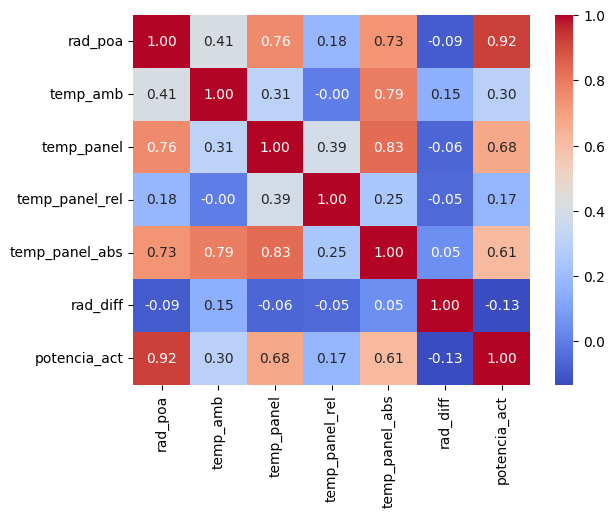

In [ ]:
main_df = main_copy.copy()

# Manipulación de variables meteorológicas
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"]) #/ (main_df["rad_celda1"] + 1)
mean_rad_diff = main_df["rad_diff"].mean()
std_rad_diff = main_df["rad_diff"].std()
main_df = main_df[(main_df["rad_diff"] >= mean_rad_diff - std_rad_diff) & (main_df["rad_diff"] <= mean_rad_diff + 6 * std_rad_diff)]
main_df["rad_diff"] = main_df["rad_diff"] / (main_df["rad_celda1"] + 1)
main_df["temp_amb"] = main_df["temp_amb"] + 273.15
main_df["temp_panel1"] = main_df["temp_panel1"] + 273.15
main_df["temp_panel2"] = main_df["temp_panel2"] + 273.15
main_df["temp_panel_abs"] = (main_df["temp_panel1"] + main_df["temp_panel2"]) / 2
main_df["temp_panel"] = (((main_df["temp_panel1"] + main_df["temp_panel2"]) / 2) - main_df["temp_amb"]) #/ (main_df["rad_poa"] + 1)
main_df["temp_panel_rel"] = main_df["temp_panel"] / main_df["rad_poa"]
main_df = main_df.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

sns.heatmap(main_df[["rad_poa", "temp_amb", "temp_panel", "temp_panel_rel", "temp_panel_abs", "rad_diff", "potencia_act"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")


<Axes: xlabel='rad_diff', ylabel='potencia_act'>

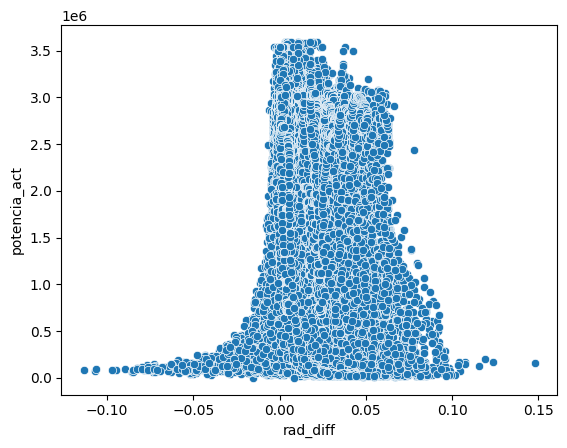

In [ ]:
sns.scatterplot(data = main_df[main_df.index.get_level_values("dispositivo_id") == 21], x = main_df["rad_diff"], y = "potencia_act") 

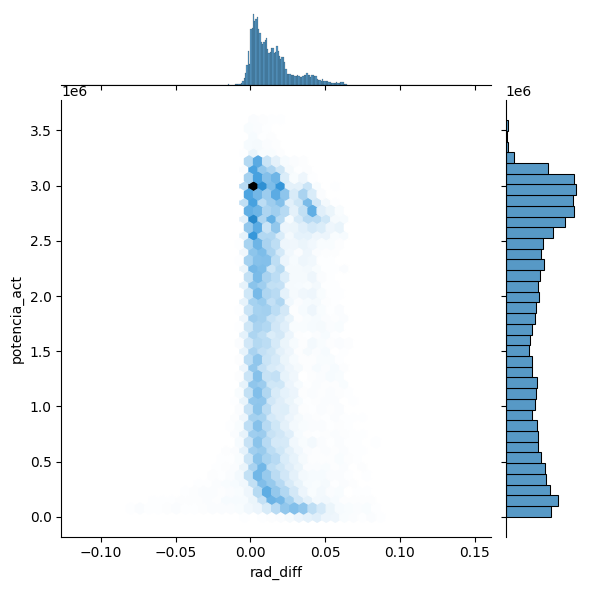

In [ ]:
sns.jointplot(data = main_df[main_df.index.get_level_values("dispositivo_id") == 21], x = main_df["rad_diff"], y = "potencia_act", kind = "hex") 


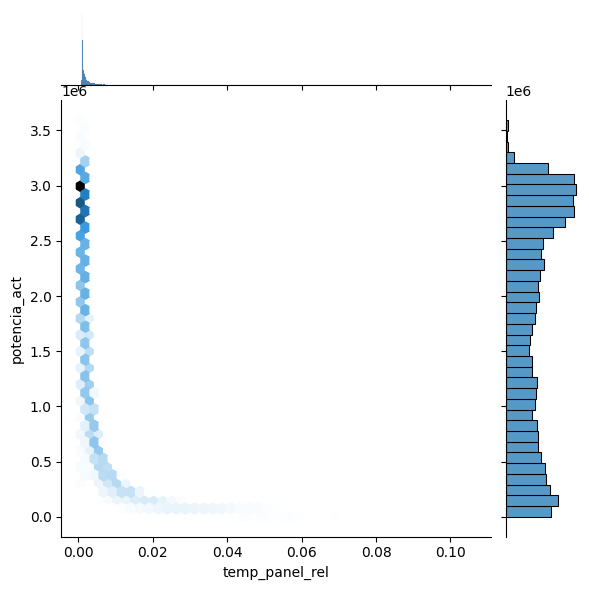

In [ ]:
sns.jointplot(data = main_df[main_df.index.get_level_values("dispositivo_id") == 21], x = main_df["temp_panel_rel"], y = "potencia_act", kind = "hex") 